In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import os
#
import ast
import sys
#
from sklearn.impute import KNNImputer
import catboost
#
from sklearn.preprocessing import LabelEncoder
from category_encoders import TargetEncoder
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
#
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
#
import shap
#
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import make_scorer
from sklearn.linear_model import LinearRegression
##from sklearn.ensemble import CatBoostRegressor  # –∏–ª–∏ —Ç–≤–æ—è –º–æ–¥–µ–ª—å
from sklearn.model_selection import RandomizedSearchCV
#
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import Ridge
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
#
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
#
from flask import Flask, request, jsonify
#
import requests
import joblib
#





In [2]:
# –ß–∏—Ç–∞–µ–º –¥–∞–Ω–Ω—ã–µ
df = pd.read_csv('data/data.csv')
##display(df)

In [3]:
df = df.drop_duplicates()
print("–û—Å—Ç–∞–ª–æ—Å—å –¥—É–±–ª–∏–∫–∞—Ç–æ–≤:", df.duplicated().sum())



–û—Å—Ç–∞–ª–æ—Å—å –¥—É–±–ª–∏–∫–∞—Ç–æ–≤: 0


–î–µ–ª–∞–µ–º –ø—Ä–µ–¥–∞–±—Ä–æ–±–æ—Ç–∫—É –Ω–µ–∫–æ—Ç–æ—Ä—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤, –∏–∑–≤–ª–µ–∫–∞—è –æ—Ç—Ç—É–¥–∞ –Ω—É–∂–Ω—ã–µ —á–∏—Å–ª–æ–≤—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –∏ –ø—Ä–∏–≤–æ–¥—è –∫ —á–∏—Å–ª–µ–Ω–Ω–æ–º—É –≤–∏–¥—É

In [4]:
df['beds'] = pd.to_numeric(df['beds'].str.extract(r'(\d+)')[0], errors='coerce')
df['baths'] = pd.to_numeric(df['baths'].str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
df['sqft'] = pd.to_numeric(df['sqft'].str.replace(',', '').str.extract(r'(\d+\.?\d*)')[0], errors='coerce')
df['target'] = pd.to_numeric(df['target'].str.replace(r'[\$,]', '', regex=True), errors='coerce')


In [5]:
# –¥–µ–ª–∞–µ–º –∑–∞–º–µ–Ω—É –∂–∞—Ä–≥–æ–Ω–Ω—ã—Ö –≤—ã—Ä–∞–∂–µ–Ω–∏–π –Ω–∞ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–µ –ø–æ–Ω—è—Ç–∏—è
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['mobile', 'prefab', 'modular']),
    'manufactured home (house)',
    df['propertyType']
)
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['mo2 le', 'mo2le']),
    'mobile',
    df['propertyType']
)
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['ca2 n', 'ca2n']),
    'cabin',
    df['propertyType']
)
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['mid century', 'mid-century']),
    'midcentury',
    df['propertyType']
)
#
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType'] = np.where(
    df['propertyType'].isin(['single-family home', 'single family', 'single family home']),
    'single family',
    df['propertyType']
)

### –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ '**has_pool**'

–æ–±—ä–µ–¥–∏–Ω—è–µ–º –≤ –æ–¥–∏–Ω –ø—Ä–∏–∑–Ω–∞–∫ –±–∞—Å—Å–µ–π–Ω—ã

In [6]:
#
df['has_pool'] = df[['private pool', 'PrivatePool']].apply(
    lambda row: (
        True if any(str(x).strip().lower() in ['yes', 'Yes'] for x in row if pd.notnull(x))
        else 'not inform'
    ),
    axis=1
)


In [7]:
#
display(df['has_pool'].unique())
display(df['has_pool'].value_counts(dropna=False))

array(['not inform', True], dtype=object)

has_pool
not inform    332644
True           44491
Name: count, dtype: int64

–ø—Ä–µ–¥–ø–æ–ª–∞–≥–∞–µ–º, —á—Ç–æ —á–∞—Å—Ç–Ω—ã–µ –±–æ–ª—å—à–∏–µ –¥–æ–º–∞ –¥–æ–ª–∂–Ω—ã –∏–º–µ—Ç—å –±–∞—Å—Å–µ–π–Ω—ã. –ü–æ—ç—Ç–æ–º—É, —á—Ç–æ–±—ã –¥–æ–ø–æ–ª–Ω–∏—Ç—å –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ —Å –±–∞—Å—Å–µ–π–Ω–∞–º–∏ –¥–µ–ª–∞–µ–º :

In [8]:
likely_pool_types = ['single family', 'house', 'villa', 'detached']
#
df['has_pool'] = df.apply(
    lambda row: True if (
        row['has_pool'] == 'not inform' and
        str(row['propertyType']).strip().lower() in likely_pool_types and
        pd.to_numeric(row['sqft'], errors='coerce') > 2500
    ) else row['has_pool'],
    axis=1
)

In [9]:
#
# —Å—Ä–∞–∑—É –∫–æ–¥–∏—Ä—É–µ–º
df['has_pool'] = df['has_pool'].apply(lambda x: 1 if x is True else 0)
#
df['has_pool'].value_counts(dropna=False).to_csv('csv/has_pool.csv')
display(df['has_pool'].value_counts(dropna=False))

has_pool
0    287159
1     89976
Name: count, dtype: int64

—É–¥–∞–ª—è–µ–º mls-id, —Ç–∞–∫ –∫–∞–∫ –ø–æ—á—Ç–∏ –≤—Å–µ –ø—Ä–æ–ø—É—Å–∫–∏   

MlsId -–æ–≥—Ä–æ–º–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö, —Ç–æ–∂–µ —É–¥–∞–ª—è–µ–º   
–£–¥–∞–ª—è–µ–º 'PrivatePool', 'private pool', —Ç–∞–∫ –∫–∞–∫ —Å–∏–ª—å–Ω–æ —Ä–∞–∑—Ä–µ–∂–µ–Ω–Ω—ã–π.

In [10]:
# —É–¥–∞–ª—è–µ–º mls-id, —Ç–∞–∫ –∫–∞–∫ –ø–æ—á—Ç–∏ –≤—Å–µ –ø—Ä–æ–ø—É—Å–∫–∏
#  MlsId -–æ–≥—Ä–æ–º–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö, —Ç–æ–∂–µ —É–¥–∞–ª—è–µ–º
print(df['MlsId'].nunique())
#
df = df.drop(columns=['PrivatePool', 'private pool', 'mls-id', 'MlsId'], errors='ignore')
#  MlsId -–æ–≥—Ä–æ–º–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö, —Ç–æ–∂–µ —É–¥–∞–ª—è–µ–º
#


232944


### –ø—Ä–∏–∑–Ω–∞–∫ '**propertyType**'

In [11]:
#
display(df['propertyType'].unique())
display(df['propertyType'].value_counts(dropna=False))
#

array(['single family', 'lot/land', 'townhouse', ...,
       'cabin/lodge, contemporary, converted barn, cottage, loft with bedrooms, log home, post & beam',
       'lake house, single detached, tudor',
       'bilevel, converted dwelling, loft with bedrooms, condo/unit'],
      dtype=object)

propertyType
single family                                                  186794
condo                                                           42525
NaN                                                             34733
lot/land                                                        20526
townhouse                                                       18392
                                                                ...  
custom, elevated, other                                             1
contemporary, farmhouse                                             1
2 stories, traditional, mediterranean, texas hill country           1
1 story, contemporary, traditional, mediterranean                   1
bilevel, converted dwelling, loft with bedrooms, condo/unit         1
Name: count, Length: 1271, dtype: int64

—Å–æ—Ö—Ä–∞–Ω—è–µ–º —É–Ω–∏–∫–∞–ª—å–Ω—ã–µ —Ç–∏–ø—ã 'propertyType'

In [12]:
#
df['propertyType'].value_counts(dropna=False).to_csv('property_types.csv')

–°–æ–∑–¥–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –¥–ª—è –≥—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∏ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π 'propertyType' (–ø–µ—Ä–≤—ã–µ 212 —Å—Ç—Ä–æ–∫)

In [13]:
# 1Ô∏è‚É£ –°–ª–æ–≤–∞—Ä—å –≥—Ä—É–ø–ø–∏—Ä–æ–≤–∫–∏ (100 –∑–Ω–∞—á–µ–Ω–∏–π)
grouping_dict = {
    'single family': 'single family',
    'condo': 'condo',
    '': 'other',
    'lot/land': 'land',
    'townhouse': 'townhouse',
    'land': 'land',
    'multi-family': 'multi-family',
    'condo/townhome/row home/co-op': 'condo',
    'traditional': 'other',
    'coop': 'coop',
    'multi family': 'multi-family',
    'high rise': 'apartment',
    'ranch': 'other',
    'mobile/manufactured': 'manufactured',
    'detached, one story': 'single family',
    'single detached, traditional': 'single family',
    'contemporary': 'other',
    'multi-family home': 'multi-family',
    '1 story': 'single family',
    'colonial': 'other',
    'mobile / manufactured': 'manufactured',
    'contemporary/modern': 'other',
    'apartment': 'apartment',
    '2 stories': 'single family',
    'mfd/mobile home': 'manufactured',
    'single detached': 'single family',
    'detached, two story': 'single family',
    'one story': 'single family',
    'transitional': 'other',
    'cooperative': 'coop',
    'florida': 'other',
    'bungalow': 'cabin',
    'farms/ranches': 'land',
    'two story': 'single family',
    'garden home': 'other',
    '2 story': 'single family',
    'cape cod': 'cabin',
    '2 stories, traditional': 'single family',
    'spanish/mediterranean': 'luxury',
    'other style': 'other',
    '1 story, traditional': 'single family',
    'other': 'other',
    'condo/townhome, traditional': 'condo',
    'singlefamilyresidence': 'single family',
    'craftsman': 'other',
    'contemporary/modern, traditional': 'other',
    'condo/townhome': 'condo',
    'condo/townhome, contemporary/modern': 'condo',
    'single detached, contemporary/modern': 'single family',
    'multiple occupancy': 'multi-family',
    'ranch, traditional': 'other',
    'mediterranean': 'luxury',
    '2 stories, contemporary': 'single family',
    'traditional, transitional': 'other',
    'custom': 'other',
    'cluster home': 'other',
    'federal': 'other',
    'urban contemporary': 'apartment',
    'split-level': 'single family',
    'victorian': 'other',
    'condominium (single level), contemporary': 'condo',
    'other (see remarks)': 'other',
    'condominium (single level)': 'condo',
    'miscellaneous': 'other',
    '1 story, contemporary': 'single family',
    'residential (<1 acre)': 'land',
    'single detached, ranch': 'single family',
    'low-rise (1-3 stories)': 'apartment',
    'ranch, one story': 'single family',
    'detached, ranch, one story': 'single family',
    'detached': 'single family',
    'townhouse, modern': 'townhouse',
    'tri-level': 'single family',
    'spanish': 'luxury',
    'key west': 'luxury',
    'condo/unit': 'condo',
    'penthouse': 'luxury',
    'detached, two story, spanish/mediterranean': 'luxury',
    'bungalow, cape cod': 'cabin',
    'tudor': 'other',
    'cottage': 'cabin',
    'duplex': 'multi-family',
    'fourplex': 'multi-family',
    'split level': 'single family',
    '1 story with basement': 'single family',
    'single detached, craftsman': 'single family',
    'a-frame': 'cabin',
    'condominium': 'condo',
    'detached, one story, spanish/mediterranean': 'luxury',
    'straight thru': 'other',
    'high rise, penthouse': 'luxury',
    'single detached, other (see remarks)': 'single family',
    'mid-century modern': 'other',
    'florida, ranch': 'other',
    '1 story, ranch': 'single family',
    'santa barbara/tuscan': 'luxury',
    'rancher': 'single family',
    'single detached, ranch, traditional': 'single family',
    'other style, traditional': 'other',
    'farmhouse': 'land',
    'mediterranean, traditional': 'luxury',
    'custom, florida': 'other',
    'multiplex': 'multi-family',
    'high-rise (8+ stories)': 'apartment',
    'single detached, contemporary/modern, traditional': 'single family',
    'high rise, split-level': 'apartment',
    'colonial, traditional': 'other',
    'french': 'other',
    'co-op': 'coop',
    '1 story, historic/older': 'single family',
    'english': 'other',
    '2 stories with basement': 'single family',
    '2 stories, mediterranean': 'luxury',
    'unknown': 'other',
    'detached, ranch': 'single family',
    'single detached, mid-century modern': 'single family',
    'bi-level': 'single family',
    'french, traditional': 'other',
    'georgian': 'other',
    'single detached, tudor': 'single family',
    'mid-rise': 'apartment',
    'florida, traditional': 'other',
    'european': 'other',
    'contemporary, florida': 'other',
    'attached or 1/2 duplex, contemporary/modern': 'multi-family',
    'modern': 'other',
    'elevated': 'other',
    'one story, spanish/mediterranean': 'luxury',
    'condo/townhome, contemporary/modern, traditional': 'condo',
    'beaux arts': 'luxury',
    'condo/townhome, hi-rise, contemporary/modern': 'condo',
    'single detached, a-frame': 'cabin',
    'coach/carriage': 'other',
    'condo/townhome, hi-rise, traditional': 'condo',
    'split level, traditional': 'single family',
    'attached or 1/2 duplex, traditional': 'multi-family',
    'multi-family': 'multi-family',
    'cape': 'cabin',
    'modernist': 'other',
    'high rise, ranch': 'other',
    'attached': 'multi-family',
    'two story, spanish/mediterranean': 'luxury',
    'french provincial': 'luxury',
    'garden apartment': 'other',
    'condominium (single level), traditional': 'condo',
    'single detached, mediterranean': 'luxury',
    'condo/townhome, other (see remarks)': 'condo',
    'contemporary, ranch': 'other',
    'cluster home, garden home': 'other',
    'craftsman, transitional': 'single family',
    'farm house': 'cabin',
    'contemporary, traditional': 'other',
    'contemporary, custom': 'other',
    'raised ranch': 'single family',
    'historical': 'other',
    'commercial/industrial': 'other',
    'manufactured house, ranch, one story': 'mobile/manufactured',
    'loft': 'other',
    '2 stories, historic/older': 'other',
    'multi-level, modern': 'other',
    'attached, ranch': 'multi-family',
    '2 stories, contemporary, traditional': 'single family',
    'art deco': 'luxury',
    '2 stories, texas hill country': 'luxury',
    'mid-rise (4-7 stories)': 'condo',
    'georgian, traditional': 'luxury',
    'split-entry': 'single family',
    'garden/zero lot line, single detached, traditional': 'single family',
    'custom, elevated': 'other',
    'multi-level': 'other',
    '1 story, ranch, traditional': 'single family',
    'charleston': 'luxury',
    'detached, spanish/mediterranean': 'luxury',
    'less than 4 floors': 'other',
    'single detached, french': 'luxury',
    'craftsman, traditional': 'single family',
    'mountain contemporary': 'luxury',
    'contemporary, modernist, transitional': 'other',
    'contemporary/modern, other style': 'other',
    '3+ stories': 'other',
    'manufactured house, manufactured home': 'mobile/manufactured',
    'coastal': 'luxury',
    'detached, patio home, two story': 'luxury',
    'english, traditional': 'luxury',
    'single detached, craftsman, traditional': 'single family',
    '3+ stories, contemporary': 'other',
    '2 story, craftsman': 'single family',
    '1 story, mediterranean': 'luxury',
    'colonial, contemporary/modern': 'luxury',
    'manufactured house, ranch, one story, manufactured home': 'mobile/manufactured',
    '1 story with basement, craftsman': 'single family',
    'attached, end unit': 'multi-family',
    'garden home, high rise': 'condo',
    'multi generational, traditional': 'single family',
    'bungalow, craftsman': 'single family',
    '1 story, texas hill country': 'luxury',
    'elevated, key west': 'other',
    'high-rise': 'condo',
    '1 story, craftsman': 'single family',
    'garden/zero lot line, single detached, contemporary/modern': 'single family',
    'florida, spanish/mediterranean': 'luxury',
    'townhome style': 'townhouse',
    'condo/townhome, hi-rise': 'condo',
    'single detached, contemporary/modern, mid-century modern': 'luxury',
    'garden/zero lot line, traditional': 'single family'
}
# 2Ô∏è‚É£ –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å–ª–æ–≤–∞—Ä—å –≤ CSV
grouping_df = pd.DataFrame(list(grouping_dict.items()), columns=['original', 'grouped'])
grouping_df.to_csv('grouping_dict.csv', index=False)
# 3Ô∏è‚É£ –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –æ–±—Ä–∞—Ç–Ω–æ
loaded_df = pd.read_csv('grouping_dict.csv')
loaded_dict = dict(zip(loaded_df['original'].str.lower().str.strip(), loaded_df['grouped']))
# 4Ô∏è‚É£ –ü—Ä–∏–º–µ–Ω—è–µ–º –∫ DataFrame
df['propertyType'] = df['propertyType'].str.lower().str.strip()
df['propertyType_clean'] = df['propertyType'].map(loaded_dict).fillna('other')
#

In [14]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–ø–∏—Å–æ–∫ —Ç–∏–ø–æ–≤ –∏–∑ —Ñ–∞–π–ª–∞
property_types = pd.read_csv('property_types.csv')

# –ü–æ–ª—É—á–∞–µ–º —Å–ø–∏—Å–æ–∫ –∑–Ω–∞—á–µ–Ω–∏–π –Ω–∞—á–∏–Ω–∞—è —Å 213-–π —Å—Ç—Ä–æ–∫–∏ (–∏–Ω–¥–µ–∫—Å–∞ 212)
types_to_replace = property_types.loc[212:, 'propertyType'].dropna().unique()
#
# –î–æ–±–∞–≤–ª—è–µ–º –≤—Ä—É—á–Ω—É—é –∑–Ω–∞—á–µ–Ω–∏–µ —Å –º–∞–ª–æ–π —á–∞—Å—Ç–æ—Ç–æ–π
types_to_replace = list(types_to_replace) + ['mobile/manufactured']

# –ó–∞–º–µ–Ω—è–µ–º –≤ –æ—Å–Ω–æ–≤–Ω–æ–º DataFrame –≤—Å–µ –Ω–µ –æ—á–µ–Ω—å —Ç–æ —á–∞—Å—Ç–æ –≤—Å—Ç—Ä–µ—á–∞–µ–º—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è –Ω–∞ other
df['propertyType_clean'] = df['propertyType_clean'].apply(
    lambda x: 'other' if x in types_to_replace else x
)


In [15]:
# –£–¥–∞–ª—è–µ–º –∏—Å—Ö–æ–¥–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
df.drop(columns=['propertyType'], inplace=True)

# –ü–µ—Ä–µ–∏–º–µ–Ω–æ–≤—ã–≤–∞–µ–º –æ—á–∏—â–µ–Ω–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
df.rename(columns={'propertyType_clean': 'propertyType'}, inplace=True)


In [16]:
df['propertyType'].value_counts(dropna=False).to_csv('property_types_result.csv')
display(df['propertyType'].value_counts(dropna=False))

propertyType
single family    197184
other             54012
condo             51293
land              31966
townhouse         18484
multi-family      12627
coop               3837
manufactured       3476
apartment          3050
luxury             1206
Name: count, dtype: int64

###  –ø—Ä–∏–∑–Ω–∞–∫ '**fireplace**'

In [17]:
def has_fireplace(value):
    if pd.isna(value):
        return False
    value = str(value).lower()
    
    # –Ø–≤–Ω—ã–µ –æ—Ç—Ä–∏—Ü–∞–Ω–∏—è
    if value in ['no', 'none', 'n/a', 'na', '0']:
        return False
    
    # –Ø–≤–Ω—ã–µ –ø–æ–¥—Ç–≤–µ—Ä–∂–¥–µ–Ω–∏—è
    if value in ['yes',' yes','yes ', 'y', 'true', '1']:
        return True
    
    # –ï—Å–ª–∏ –µ—Å—Ç—å —Å–ª–æ–≤–æ fireplace ‚Äî —Å—á–∏—Ç–∞–µ–º, —á—Ç–æ –µ—Å—Ç—å
    if 'fireplace' in value:
        return True
    
    # –ï—Å–ª–∏ —á–∏—Å–ª–æ –±–æ–ª—å—à–µ –Ω—É–ª—è
    try:
        return float(value) > 0
    except:
        return False

def count_fireplaces(value):
    if pd.isna(value):
        return 0
    value = str(value).lower()
    
    # –ò—â–µ–º —á–∏—Å–ª–æ
    match = re.search(r'\d+', value)
    if match:
        return int(match.group())
    
    if 'fireplace' in value:
        return 1  # –µ—Å–ª–∏ –Ω–µ —É–∫–∞–∑–∞–Ω–æ —á–∏—Å–ª–æ, –Ω–æ –∫–∞–º–∏–Ω –µ—Å—Ç—å
    
    return 0

df['fireplace_count'] = df['fireplace'].apply(count_fireplaces)
#
df = df.drop(columns=['fireplace'], errors='ignore')

In [18]:
df.loc[df['fireplace_count'] == 1000, 'fireplace_count'] = 1
display(df['fireplace_count'].value_counts(dropna=False))

fireplace_count
0     356211
1      17449
2       2530
3        616
4        197
5         65
6         35
7         18
8          5
9          3
10         3
11         2
12         1
Name: count, dtype: int64

## '–ø—Ä–∏–∑–Ω–∞–∫ '**status**'

In [19]:
df['status'].value_counts(dropna=False).to_csv('status.csv')
display(df['status'].value_counts(dropna=False))

status
for sale                156058
Active                  105207
For sale                 43464
NaN                      39917
foreclosure               6425
                         ...  
Contingent   No Show         1
Coming soon: Oct 24.         1
Coming soon: Oct 21.         1
Coming soon: Nov 14.         1
Coming soon: Dec 23.         1
Name: count, Length: 160, dtype: int64

—Å–ª–æ–≤–∞—Ä—å –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞ 'status'

In [20]:
#
status_grouping_dict = {
    # –û—Å–Ω–æ–≤–Ω—ã–µ —Å—Ç–∞—Ç—É—Å—ã –ø—Ä–æ–¥–∞–∂–∏
    'for sale': 'for sale',
    'active': 'for sale',
    'new construction': 'for sale',
    'new': 'for sale',
    'price change': 'for sale',
    'back on market': 'for sale',
    'listing extended': 'for sale',
    'a active': 'for sale',
    'active with offer': 'for sale',
    'active backup': 'for sale',
    'active with contingencies': 'for sale',
    'active/contingent': 'for sale',
    'active - auction': 'for sale',
    'active - contingent': 'for sale',
    'active option contract': 'for sale',
    'active option': 'for sale',
    'active contingency': 'for sale',
    'active contingent': 'for sale',
    'active with contract': 'for sale',
    
    # –ê—Ä–µ–Ω–¥–∞
    'for rent': 'rental',
    'condo for rent': 'rental',
    'apartment for rent': 'rental',
    
    # –ü—Ä–æ–¥–∞–Ω–æ
    'recently sold': 'sold',
    'closed': 'sold',
    'sold: $285,000': 'sold',
    'sold: $15,000': 'sold',
    
    # –í –æ–∂–∏–¥–∞–Ω–∏–∏
    'pending': 'pending',
    'pending continue to show': 'pending',
    'pending taking backups': 'pending',
    'pending with contingencies': 'pending',
    'pending inspection': 'pending',
    'pending offer approval': 'pending',
    'pending sale': 'pending',
    'pending - continue to show': 'pending',
    'pending - taking backups': 'pending',
    'pending w/insp finance': 'pending',
    'pending w/backup wanted': 'pending',
    'pending backups wanted': 'pending',
    'pending (do not show)': 'pending',
    'pending w/ cont.': 'pending',
    'pending fe': 'pending',
    'pending sh': 'pending',
    'pending ab': 'pending',
    'pending bring backup': 'pending',
    'pending   continue to show   financing': 'pending',
    
    # –ü–æ–¥ –∫–æ–Ω—Ç—Ä–∞–∫—Ç–æ–º
    'under contract': 'under contract',
    'under contract show': 'under contract',
    'under contract   showing': 'under contract',
    'under contract backups': 'under contract',
    'under contract - show': 'under contract',
    'under contract - no show': 'under contract',
    'under contract taking back up offers': 'under contract',
    'under contract w/ bckp': 'under contract',
    'u under contract': 'under contract',
    'active under contract': 'under contract',
    'under contract backups': 'under contract',
    
    # –ö–æ–Ω—Ç–∏–Ω–≥–µ–Ω—Ç–Ω—ã–µ —Å—Ç–∞—Ç—É—Å—ã
    'contingent': 'contingent',
    'contingent finance and inspection': 'contingent',
    'contingent show': 'contingent',
    'contingent take backup': 'contingent',
    'contingent escape': 'contingent',
    'contingent - financing': 'contingent',
    'contingent - sale of home': 'contingent',
    'contingent   show': 'contingent',
    'contingent   release': 'contingent',
    'contingent   foreclosure': 'contingent',
    'contingent lien holder release': 'contingent',
    'contingent no show': 'contingent',
    'contingency contract': 'contingent',
    'contingency 48 hr (+/ )': 'contingent',
    'conting accpt backups': 'contingent',
    
    # –ê—É–∫—Ü–∏–æ–Ω—ã –∏ –±–∞–Ω–∫—Ä–æ—Ç—Å—Ç–≤–∞
    'auction': 'auction',
    'auction - active': 'auction',
    ' / auction': 'auction',
    'pre-foreclosure': 'foreclosure',
    'pre-foreclosure / auction': 'foreclosure',
    'foreclosure': 'foreclosure',
    'foreclosed': 'foreclosure',
    
    # Coming soon
    'coming soon': 'coming soon',
    'coming soon: nov 29.': 'coming soon',
    'coming soon: dec 6.': 'coming soon',
    'coming soon: dec 5.': 'coming soon',
    'coming soon: dec 4.': 'coming soon',
    'coming soon: dec 13.': 'coming soon',
    'coming soon: nov 27.': 'coming soon',
    'coming soon: dec 7.': 'coming soon',
    'coming soon: nov 19.': 'coming soon',
    'coming soon: nov 28.': 'coming soon',
    'coming soon: dec 10.': 'coming soon',
    'coming soon: dec 3.': 'coming soon',
    'coming soon: nov 30.': 'coming soon',
    'coming soon: dec 9.': 'coming soon',
    'coming soon: dec 2.': 'coming soon',
    'coming soon: dec 14.': 'coming soon',
    'coming soon: oct 30.': 'coming soon',
    'coming soon: nov 13.': 'coming soon',
    'coming soon: dec 20.': 'coming soon',
    'coming soon: dec 11.': 'coming soon',
    'coming soon: nov 22.': 'coming soon',
    'coming soon: dec 18.': 'coming soon',
    'coming soon: nov 21.': 'coming soon',
    'coming soon: dec 24.': 'coming soon',
    'coming soon: dec 16.': 'coming soon',
    'coming soon: nov 23.': 'coming soon',
    'coming soon: dec 12.': 'coming soon',
    'coming soon: nov 5.': 'coming soon',
    'coming soon: nov 12.': 'coming soon',
    'coming soon: dec 1.': 'coming soon',
    'coming soon: nov 25.': 'coming soon',
    'coming soon: dec 27.': 'coming soon',
    'coming soon: nov 26.': 'coming soon',
    'coming soon: nov 17.': 'coming soon',
    'coming soon: nov 11.': 'coming soon',
    'coming soon: nov 8.': 'coming soon',
    'coming soon: oct 29.': 'coming soon',
    'coming soon: dec 15.': 'coming soon',
    'coming soon: dec 25.': 'coming soon',
    'coming soon: oct 24.': 'coming soon',
    'coming soon: oct 21.': 'coming soon',
    'coming soon: nov 14.': 'coming soon',
    'coming soon: dec 23.': 'coming soon',
    
    # –ü—Ä–æ—á–µ–µ
    'contract': 'other',
    'option contract': 'other',
    'lease/purchase': 'other',
    'lease/purchase pending': 'other',
    'accepting backups': 'other',
    'backup contract': 'other',
    'backup': 'other',
    'conditional contract': 'other',
    'temporary active': 'other',
    're activated': 'other',
    'reactivated': 'other',
    'offer pending signature': 'other',
    'ct insp - inspection contingency': 'other',
    'due diligence period': 'other',
    'contract contingent on buyer sale': 'other',
    'c continue show': 'other',
    'c': 'other',
    'p': 'other',
    'pi': 'other',
    'pf': 'other',
    'ps': 'other',
    'uc continue to show': 'other',
    'p pending sale': 'other',
    'contract p': 'other',
    'pending   continue to show': 'pending',
    'pending (do not show)': 'pending',
    'pending w/escape clause': 'pending'
}

# 2Ô∏è‚É£ –°–æ—Ö—Ä–∞–Ω—è–µ–º —Å–ª–æ–≤–∞—Ä—å –≤ CSV
grouping_df = pd.DataFrame(list(status_grouping_dict.items()), columns=['original', 'grouped'])
grouping_df.to_csv('status_dict.csv', index=False)
# 3Ô∏è‚É£ –ó–∞–≥—Ä—É–∂–∞–µ–º —Å–ª–æ–≤–∞—Ä—å –æ–±—Ä–∞—Ç–Ω–æ
loaded_df = pd.read_csv('status_dict.csv')
loaded_dict = dict(zip(loaded_df['original'].str.lower().str.strip(), loaded_df['grouped']))
#
def clean_status(value):
    if pd.isna(value):
        return 'other'
    value = str(value).lower().strip()
    
    # –£–ø—Ä–æ—â—ë–Ω–Ω–∞—è –ª–æ–≥–∏–∫–∞ –¥–ª—è "coming soon"
    if 'coming soon' in value:
        return 'coming soon'
    if 'sold' in value:
        return 'sold'
    
    return status_grouping_dict.get(value, 'other')

df['status_clean'] = df['status'].apply(clean_status)
df['status_clean'].value_counts()
#
df = df.drop(columns=['status'], errors='ignore')




### –ø—Ä–∏–∑–Ω–∞–∫ '**stories**'

In [21]:
df['stories'].value_counts(dropna=False).to_csv('stories.csv')
display(df['stories'].value_counts(dropna=False))

stories
NaN                                  150674
1.0                                   67451
2.0                                   55283
1                                     23085
2                                     18146
                                      ...  
1.2                                       1
Manufactured Home, Non-Site Built         1
Bedroom - Split Plan                      1
78                                        1
65.0                                      1
Name: count, Length: 348, dtype: int64

In [22]:
stories_grouping_dict = {
    # –û–¥–Ω–æ—ç—Ç–∞–∂–Ω—ã–µ
    '1': '1 story',
    '1.0': '1 story',
    '1.00': '1 story',
    '1.0000': '1 story',
    '1.000': '1 story',
    '1 Story': '1 story',
    'One': '1 story',
    'One Story': '1 story',
    '1 Level': '1 story',
    'One Level': '1 story',
    '1 Story/Ranch': '1 story',
    'Ranch': '1 story',
    'Ranch/1 Story': '1 story',
    '1 Level, Site Built': '1 story',
    '1 Level, Condo': '1 story',
    '1 Level, Townhouse': '1 story',
    '1 Level, Site Built, Townhouse': '1 story',
    '1 Level, Condo, Site Built': '1 story',
    '1 Story Basement': '1 story',
    '1 Story/F.R.O.G.': '1 story',
    '1 Story, Hillside': '1 story',
    
    # –ü–æ–ª—É—Ç–æ—Ä–∞—ç—Ç–∞–∂–Ω—ã–µ
    '1.5': '1.5 story',
    '1.50': '1.5 story',
    '1.5000': '1.5 story',
    '1.5 Story': '1.5 story',
    '1.5 Level': '1.5 story',
    '1.5 Stories': '1.5 story',
    '1.5 Story/Basement': '1.5 story',
    '1.5 Level, Site Built': '1.5 story',
    '1.5 Level, Site Built, Tri-Level': '1.5 story',
    '1 1/2 Story': '1.5 story',
    '1 1/2 Levels': '1.5 story',
    'One and One Half': '1.5 story',
    
    # –î–≤—É—Ö—ç—Ç–∞–∂–Ω—ã–µ
    '2': '2 story',
    '2.0': '2 story',
    '2.00': '2 story',
    '2.0000': '2 story',
    '2 Story': '2 story',
    'Two': '2 story',
    'Two Stories': '2 story',
    '2 Stories': '2 story',
    '2 Level': '2 story',
    '2 Levels': '2 story',
    '2 Level, Site Built': '2 story',
    '2 Level, Site Built, Townhouse': '2 story',
    '2 Level, Condo, Site Built': '2 story',
    '2 Story/Basement': '2 story',
    '2 Story, Split Level': '2 story',
    '2 Story, Tri Level': '2 story',
    '2 Story or 2 Level': '2 story',
    '2 Stories, Townhouse': '2 story',
    
    # 2.5 —ç—Ç–∞–∂–∞
    '2.5': '2.5 story',
    '2.50': '2.5 story',
    '2.5000': '2.5 story',
    '2.5 Story': '2.5 story',
    '2.5 Story/Basement': '2.5 story',
    
    # –¢—Ä—ë—Ö—ç—Ç–∞–∂–Ω—ã–µ
    '3': '3 story',
    '3.0': '3 story',
    '3.00': '3 story',
    '3.0000': '3 story',
    '3 Story': '3 story',
    '3 Stories': '3 story',
    '3 Story/Basement': '3 story',
    '3+': '3 story',
    '3+ Story': '3 story',
    '3 Level': '3 story',
    '3 Level, Site Built': '3 story',
    '3 Level, Townhouse': '3 story',
    '3 Level, Site Built, Townhouse': '3 story',
    '3 Level, Site Built, Tri-Level': '3 story',
    '3 Level, Site Built, Split Level': '3 story',
    
    # –ú–Ω–æ–≥–æ—ç—Ç–∞–∂–Ω—ã–µ (4+)
    '4': '4+ stories',
    '4.0': '4+ stories',
    '4.00': '4+ stories',
    '4 Story': '4+ stories',
    '4 Stories': '4+ stories',
    '5': '4+ stories',
    '5.0': '4+ stories',
    '5.00': '4+ stories',
    '6': '4+ stories',
    '6.0': '4+ stories',
    '6.00': '4+ stories',
    '6+ Stories': '4+ stories',
    '7': '4+ stories',
    '7.0': '4+ stories',
    '7.00': '4+ stories',
    '8': '4+ stories',
    '8.0': '4+ stories',
    '9': '4+ stories',
    '9.0': '4+ stories',
    '10.0': '4+ stories',
    '11.0': '4+ stories',
    '12.0': '4+ stories',
    '13.0': '4+ stories',
    '14.0': '4+ stories',
    '15.0': '4+ stories',
    '16.0': '4+ stories',
    '17.0': '4+ stories',
    '18.0': '4+ stories',
    '19.0': '4+ stories',
    '20.0': '4+ stories',
    '21.0': '4+ stories',
    '22.0': '4+ stories',
    '23.0': '4+ stories',
    '24.0': '4+ stories',
    '25.0': '4+ stories',
    '26.0': '4+ stories',
    '27.0': '4+ stories',
    '28.0': '4+ stories',
    '29.0': '4+ stories',
    '30.0': '4+ stories',
    '31.0': '4+ stories',
    '32.0': '4+ stories',
    '33.0': '4+ stories',
    '34.0': '4+ stories',
    '35.0': '4+ stories',
    '36.0': '4+ stories',
    '37.0': '4+ stories',
    '38.0': '4+ stories',
    '39.0': '4+ stories',
    '40.0': '4+ stories',
    '41.0': '4+ stories',
    '42.0': '4+ stories',
    '43.0': '4+ stories',
    '44.0': '4+ stories',
    '45.0': '4+ stories',
    '46.0': '4+ stories',
    '47.0': '4+ stories',
    '48.0': '4+ stories',
    '49.0': '4+ stories',
    '50.0': '4+ stories',
    '51.0': '4+ stories',
    '52.0': '4+ stories',
    '54.0': '4+ stories',
    '55.0': '4+ stories',
    '56.0': '4+ stories',
    '57.0': '4+ stories',
    '58.0': '4+ stories',
    '60.0': '4+ stories',
    '63.0': '4+ stories',
    '64.0': '4+ stories',
    '65.0': '4+ stories',
    '66.0': '4+ stories',
    '70.0': '4+ stories',
    '75.0': '4+ stories',
    '77.0': '4+ stories',
    '78.0': '4+ stories',
    '80.0': '4+ stories',
    '90.0': '4+ stories',
    '91.0': '4+ stories',
    '95.0': '4+ stories',
    '96.0': '4+ stories',
    '1002.0': '4+ stories',
    '1120.0': '4+ stories',
    
    # –ú–Ω–æ–≥–æ—É—Ä–æ–≤–Ω–µ–≤—ã–µ –∏ –Ω–µ—Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω—ã–µ
    'Multi-Level': 'multi/split',
    'Multi/Split': 'multi/split',
    'Split Level': 'multi/split',
    'Tri-Level': 'multi/split',
    'Bi-Level': 'multi/split',
    'Split Foyer': 'multi/split',
    'Split Entry (Bi-Level)': 'multi/split',
    'Multi-Story': 'multi/split',
    'Tri/Multi Level': 'multi/split',
    'Multi Level': 'multi/split',
    'Split Level w/ Sub': 'multi/split',
    'Multi Level, Tri Level': 'multi/split',
    'Three Or More': 'multi/split',
    'Three Or More Levels': 'multi'
}
def clean_stories(value):
    if pd.isna(value):
        return 'unknown'
    
    value = str(value).strip().lower()
    
    # –£–¥–∞–ª–∏–º –ª–∏—à–Ω–∏–µ —Å–∏–º–≤–æ–ª—ã
    value = value.replace('"', '').replace(',', '').replace('  ', ' ')
    
    # –ü—Ä–∏–≤–µ–¥—ë–º –∫ —Å—Ç–∞–Ω–¥–∞—Ä—Ç–Ω–æ–º—É –≤–∏–¥—É
    return stories_grouping_dict.get(value.title(), 'other')
#
df['stories_clean'] = df['stories'].apply(clean_stories)
df['stories_clean'].value_counts()
#

stories_clean
unknown        150674
1 story        100129
2 story         81450
3 story         17135
other           15029
4+ stories      10246
1.5 story        1185
multi/split      1066
2.5 story         196
multi              25
Name: count, dtype: int64

In [23]:
# –°–ø–∏—Å–æ–∫ —Ç–∏–ø–æ–≤, –∫–æ—Ç–æ—Ä—ã–µ —Å—á–∏—Ç–∞–µ–º –∫–æ—Ç—Ç–µ–¥–∂–∞–º–∏
cottage_types = ['single family', 'land', 'manufactured', 'luxury']

# –ó–∞–º–µ–Ω—è–µ–º unknown –Ω–∞ cottage, –µ—Å–ª–∏ —Ç–∏–ø –ø–æ–¥—Ö–æ–¥–∏—Ç
df.loc[
    (df['stories_clean'] == 'unknown') & 
    (df['propertyType'].isin(cottage_types)),
    'stories_clean'
] = 'cottage'
#
df['stories_clean'].value_counts()
#

stories_clean
1 story        100129
2 story         81450
cottage         78730
unknown         71944
3 story         17135
other           15029
4+ stories      10246
1.5 story        1185
multi/split      1066
2.5 story         196
multi              25
Name: count, dtype: int64

In [24]:
df = df.drop(columns=['stories'], errors='ignore')


—Ä–∞—Å–∫—Ä—ã–≤–∞–µ–º —Å–ª–æ–≤–∞—Ä–∏ **homefacts** –∏ **schools**

In [25]:
def parse_home_facts(row):
    try:
        data = ast.literal_eval(row)
        facts = data.get('atAGlanceFacts', [])
        return {item['factLabel']: item['factValue'] for item in facts}
    except:
        return {}
#
# –†–∞—Å–ø–∞—Ä—Å–∏—Ç—å homeFacts
parsed_homefacts = df['homeFacts'].apply(parse_home_facts)
##homefacts_df = pd.DataFrame(parsed_homefacts.tolist())
homefacts_df = pd.DataFrame(parsed_homefacts.tolist()).add_prefix('home_')
df = pd.concat([df, homefacts_df], axis=1)
#
def parse_schools(row):
    try:
        schools_list = ast.literal_eval(row)
        if not schools_list or not isinstance(schools_list, list):
            return {}
        
        school_data = schools_list[0]  # –ë–µ—Ä—ë–º –ø–µ—Ä–≤—ã–π —Å–ª–æ–≤–∞—Ä—å –∏–∑ —Å–ø–∏—Å–∫–∞
        names = school_data.get('name', [])
        ratings = school_data.get('rating', [])
        distances = school_data.get('data', {}).get('Distance', [])
        grades = school_data.get('data', {}).get('Grades', [])
        
        # –°–æ–±–∏—Ä–∞–µ–º —Å–ø–∏—Å–∫–∏ –≤ —Å—Ç—Ä–æ–∫–∏
        return {
            'school_names': ', '.join(names),
            'school_ratings': ', '.join(ratings),
            'school_distances': ', '.join(distances),
            'school_grades': ', '.join(grades)
        }
    except:
        return {}

# –†–∞—Å–ø–∞—Ä—Å–∏—Ç—å schools
#
parsed_schools = df['schools'].apply(parse_schools)
schools_df = pd.DataFrame(parsed_schools.tolist())
df = pd.concat([df, schools_df], axis=1)
#



### –ø—Ä–∏–∑–Ω–∞–∫ '**beds**'

In [26]:
df['beds'].value_counts(dropna=False).to_csv('beds.csv')
display(df['beds'].value_counts(dropna=False))

beds
NaN      108885
3.0      105962
4.0       69091
2.0       50342
5.0       22006
          ...  
248.0         1
831.0         1
63.0          1
38.0          1
840.0         1
Name: count, Length: 79, dtype: int64

In [27]:
# –∑–∞–ø–∏—Å—ã–≤–∞–µ–º –≤ —Ñ–∞–π–ª —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ beds >10
df[df['beds'] > 10]['beds'].value_counts().sort_index().to_csv('beds_escape.csv')

In [28]:
# —Ñ–∏–ª—å—Ç—Ä—É–µ–º –µ—Å–ª–∏ —Å–ø–∞–ª–µ–Ω –±–æ–ª—å—à–µ 10
#df = df[df['beds'] <= 10]  # –∏–ª–∏ –¥—Ä—É–≥–æ–π –ø–æ—Ä–æ–≥
# –∑–∞–º–µ–Ω—è–µ–º –±–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ø–∞–ª–µ–Ω –Ω–∞ 10
#
df['beds'] = np.where(df['beds'] > 10, 10, df['beds'])


–ì—Ä–∞—Ñ–∏–∫ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–ø–∞–ª–µ–Ω  '**beds**' 

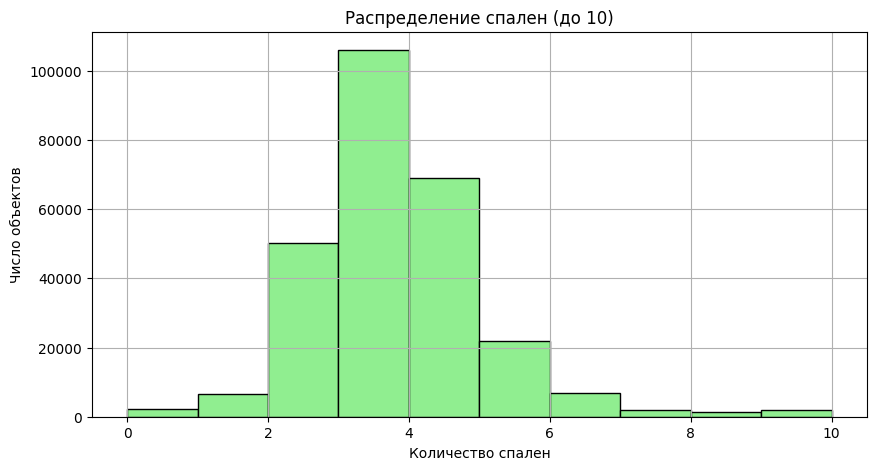

In [29]:
plt.figure(figsize=(10,5))
df[df['beds'] <= 10]['beds'].hist(bins=10, color='lightgreen', edgecolor='black')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–ø–∞–ª–µ–Ω (–¥–æ 10)')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ø–∞–ª–µ–Ω')
plt.ylabel('–ß–∏—Å–ª–æ –æ–±—ä–µ–∫—Ç–æ–≤')
plt.grid(True)
plt.show()


In [30]:
# –ó–∞–ø–æ–ª–Ω–∏–º –ø—Ä–æ–ø—É—Å–∫–∏ beads –º–µ–¥–∏–∞–Ω–æ–π
median_beds = df['beds'].median()
df['beds'] = df['beds'].fillna(median_beds)
#
df['beds'] = df['beds'].astype(int) # –ø—Ä–µ–≤—Ä–∞—â–∞–µ–º –≤ —Ü–µ–ª—ã–π —Ç–∏–ø
#

### –ø—Ä–∏–∑–Ω–∞–∫ '**baths**'

In [31]:
df['baths'].value_counts(dropna=False).to_csv('baths.csv')
display(df['baths'].value_counts(dropna=False))

baths
NaN     107858
2.0     106811
3.0      67332
4.0      26332
1.0      22927
         ...  
25.0         1
55.0         1
14.5         1
43.0         1
68.0         1
Name: count, Length: 85, dtype: int64

–ì—Ä–∞—Ñ–∏–∫–∏ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ —Å–ø–∞–ª–µ–Ω  '**baths**' 

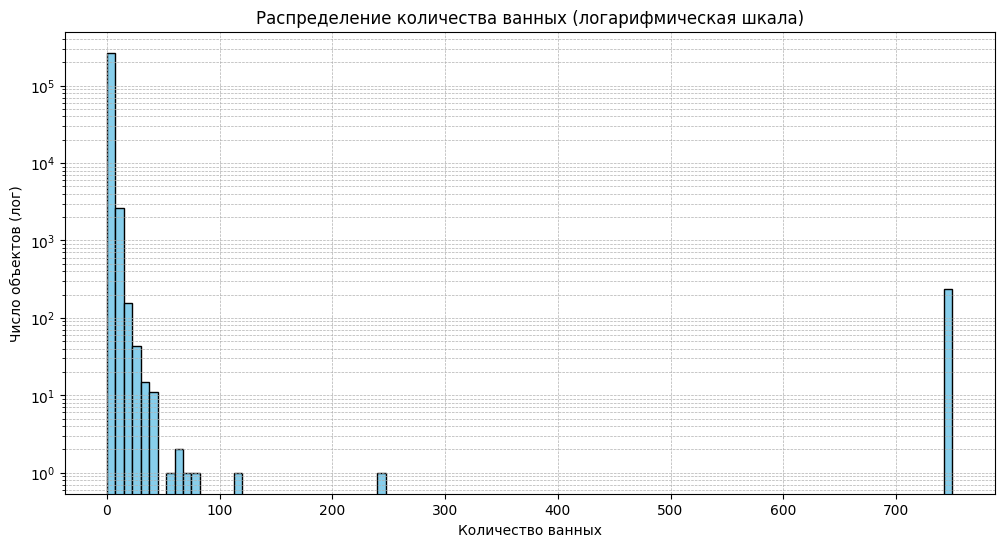

In [32]:
plt.figure(figsize=(12,6))
df['baths'].hist(bins=100, color='skyblue', edgecolor='black')
plt.yscale('log')  # üî• –í–æ—Ç —ç—Ç–∞ —Å—Ç—Ä–æ–∫–∞ –¥–µ–ª–∞–µ—Ç –æ—Å—å Y –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–π
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –≤–∞–Ω–Ω—ã—Ö (–ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–∞—è —à–∫–∞–ª–∞)')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–Ω–Ω—ã—Ö')
plt.ylabel('–ß–∏—Å–ª–æ –æ–±—ä–µ–∫—Ç–æ–≤ (–ª–æ–≥)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()

–ù–∞ –≥—Ä–∞—Ñ–∏–∫–µ –≤–∏–¥–Ω—ã –æ—á–µ–≤–∏–¥–Ω—ã–µ –≤—ã–±—Ä–æ—Å—ã, –±–æ–ª—å—à–µ 100 –≤–∞–Ω–Ω—ã—Ö –∫–æ–º–Ω–∞—Ç.–î–∞–∂–µ –ø–æ—Å–ª–µ 50 –≤–∞–Ω–Ω –º–æ–∂–Ω–æ —Å—á–∏—Ç–∞—Ç—å –≤—ã–±—Ä–æ—Å–∞–º–∏, —Ç–∞–∫ –∫–∞–∫ —ç—Ç–æ –µ–¥–∏–Ω–∏—á–Ω—ã–µ —Å–ª—É—á–∞–∏
–≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–µ —Å –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–π —à–∫–∞–ª–æ–π –ø–æ y

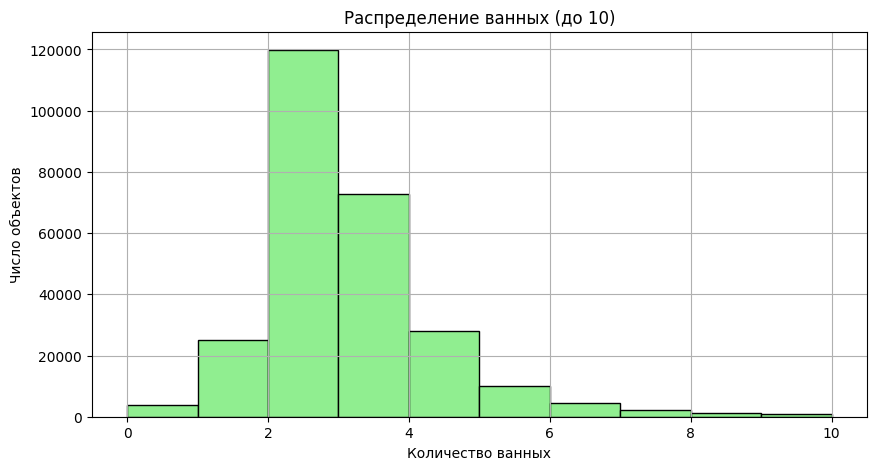

In [33]:
plt.figure(figsize=(10,5))
df[df['baths'] <= 10]['baths'].hist(bins=10, color='lightgreen', edgecolor='black')
plt.title('–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –≤–∞–Ω–Ω—ã—Ö (–¥–æ 10)')
plt.xlabel('–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–Ω–Ω—ã—Ö')
plt.ylabel('–ß–∏—Å–ª–æ –æ–±—ä–µ–∫—Ç–æ–≤')
plt.grid(True)
plt.show()

–ù–∞ —ç—Ç–æ–º –≥—Ä–∞—Ñ–∏–∫–µ –≤–∏–¥–Ω–æ, —á—Ç–æ —Ä–µ–∞–ª—å–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–Ω–Ω—ã—Ö –∫–æ–º–Ω–∞—Ç –∑–∞–∫–∞–Ω—á–∏–≤–∞–µ—Ç—Å—è –Ω–∞ 10. –û—Å—Ç–∞–ª—å–Ω–æ–µ –º–æ–∂–Ω–æ —Å—á–∏—Ç–∞—Ç—å –≤—ã–±—Ä–æ—Å–∞–º–∏.

In [34]:
# –ó–∞–ø–æ–ª–Ω–∏–º –ø—Ä–æ–ø—É—Å–∫–∏ beads –º–µ–¥–∏–∞–Ω–æ–π
median_baths = df['baths'].median()
df['baths'] = df['baths'].fillna(median_baths)
#
df['baths'] = df['baths'].astype(int) # –ø—Ä–µ–≤—Ä–∞—â–∞–µ–º –≤ —Ü–µ–ª—ã–π —Ç–∏–ø
#
df['baths'] = np.where(df['baths'] > 10, 10, df['baths'])
#

### –ø—Ä–∏–∑–Ω–∞–∫ '**target**'

–∑–∞–ø–æ–ª–Ω—è–µ–º –Ω–µ–¥–æ—Å—Ç–∞—é—â–∏–µ ~10000 –ø—Ä–æ–ø—É—Å–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é **–∏–º–ø—É—Ç–∞—Ü–∏–∏**, –∏—Å–ø–æ–ª—å–∑—É—è bath –∏ beds


In [35]:
#
imputer = KNNImputer()
df['target'] = imputer.fit_transform(df[['target', 'baths', 'beds']])[:, 0]

### –ø—Ä–∏–∑–Ω–∞–∫ '**home_Price/sqft**' - —Ü–µ–Ω–∞ –∑–∞ –∫–≤–∞–¥—Ä–∞—Ç–Ω—ã–π –º–µ—Ç—Ä.

In [36]:
df['home_Price/sqft'].value_counts(dropna=False).to_csv('home_Price_sqft.csv')
display(df['home_Price/sqft'].value_counts(dropna=False))

home_Price/sqft
None                58525
                     5185
No Data              1241
$1/sqft               974
No Info               954
                    ...  
$10714 / Sq. Ft.        1
$1,506                  1
$3,077/sqft             1
$2,244/sqft             1
$1,207                  1
Name: count, Length: 6506, dtype: int64

—ç—Ç–æ—Ç –ø—Ä–∏–∑–Ω–∞–∫ –≤–µ—Å—å–º–∞ –∑–∞–º—É—Å–æ—Ä–µ–Ω–Ω—ã–π, –∫ —Ç–æ–º—É–∂–µ —É –Ω–∞—Å –µ—Å—Ç—å –æ—á–∏—â–µ–Ω–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ target –∏ sqft. –¢–∞–∫ —á—Ç–æ home_price/sqft –≤–ø–æ–ª–Ω–µ —Ä–∞–∑—É–º–Ω–æ —É–¥–∞–ª–∏—Ç—å.

In [37]:
df = df.drop(columns=['home_Price/sqft'], errors='ignore')
#
df = df.drop(columns=['schools', 'homeFacts'], errors='ignore')



### –ø—Ä–∏–∑–Ω–∞–∫ '**sqft**'

In [38]:
# –§–∏–ª—å—Ç—Ä—É–µ–º —Å—Ç—Ä–æ–∫–∏, –≥–¥–µ –ø–ª–æ—â–∞–¥—å —Ä–∞–≤–Ω–∞ –Ω—É–ª—é
zero_sqft = df[df['sqft'] == 0.0]

# –í—ã–±–∏—Ä–∞–µ–º 20 —Å–ª—É—á–∞–π–Ω—ã—Ö —Å—Ç—Ä–æ–∫
sample = zero_sqft.sample(n=20, random_state=42)

# –í—ã–≤–æ–¥–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
##display(sample)

–ú—ã –ø—Ä–µ–¥–≤–∞—Ä–∏—Ç–µ–ª—å–Ω–æ —É–±–µ–¥–∏–ª–∏—Å—å, —á—Ç–æ sqft = 0 —Å–∫–æ—Ä–µ–µ –ø—Ä–æ—Å—Ç–æ –ø–æ –æ—à–∏–±–∫–µ –∏ –∑–∞–º–µ–Ω—è–µ–º –Ω—É–ª–∏ –Ω–∞ NaN

—Ç–µ–ø–µ—Ä—å –∑–∞–ø–æ–ª–Ω—è–µ–º –Ω–µ–¥–æ—Å—Ç–∞—é—â–∏–µ ~50000 –ø—Ä–æ–ø—É—Å–∫–æ–≤ —Å –ø–æ–º–æ—â—å—é **–∏–º–ø—É—Ç–∞—Ü–∏–∏**, –∏—Å–ø–æ–ª—å–∑—É—è –ø—Ä–∏–∑–Ω–∞–∫–∏ '**bath**' –∏ '**beds**'

In [39]:
# –ó–∞–º–µ–Ω—è–µ–º 0 –Ω–∞ NaN –≤ –ø—Ä–∏–∑–Ω–∞–∫–µ 'sqft'
df['sqft'] = df['sqft'].replace(0.0, np.nan)

In [40]:
original_baths_beds = df[['baths', 'beds']].copy()
df[['baths', 'beds']] = df[['baths', 'beds']].replace(0.0, np.nan) # –≤—Ä–µ–º–µ–Ω–Ω–æ —É–±–∏—Ä–∞–µ–º –Ω—É–ª–µ–≤—ã–µ baths –∏ beds

In [41]:
#
imputer = KNNImputer()
df['sqft'] = imputer.fit_transform(df[['sqft', 'baths', 'beds']])[:, 0]
#

In [42]:
df[['baths', 'beds']] = original_baths_beds # –≤–æ–∑–≤—Ä–∞—â–∞–µ–º –Ω—É–ª–∏ –æ–±—Ä–∞—Ç–Ω–æ

In [43]:
df['sqft'].value_counts(dropna=False).to_csv('sqft.csv')
##display(df['sqft'].value_counts(dropna=False))

### –ø—Ä–∏–∑–Ω–∞–∫ '**home_lotsize**'  - —Ä–∞–∑–º–µ—Ä –∑–µ–º–µ–ª—å–Ω–æ–≥–æ —É—á–∞—Å—Ç–∫–∞

In [44]:
#
df['home_lotsize'].value_counts(dropna=False).head(2000).to_csv('home_lotsize_2000.csv')
##df['home_lotsize'].value_counts(dropna=False).to_csv('home_lotsize.csv')
display(df['home_lotsize'].value_counts(dropna=False))

home_lotsize
                  33055
None              28387
‚Äî                 25251
No Data            5329
-- sqft lot        3819
                  ...  
10,833 Sq. Ft.        1
9,735 sqft            1
2541                  1
5096                  1
28.40 acres           1
Name: count, Length: 37395, dtype: int64

In [45]:
# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ 'home_lotaize' –∏ –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω–∏—è –≤ sqft
def convert_to_sqft(value):
    if pd.isna(value) or str(value).strip() in ['No Data', '‚Äî', '-- sqft lot', '', ' ']:
        return None
    value = str(value).lower().replace(',', '').strip()
    
    # –ï—Å–ª–∏ —É–∫–∞–∑–∞–Ω–æ –≤ sqft
    if 'sqft' in value or 'sq. ft.' in value:
        match = re.search(r'(\d*\.?\d+)', value)
        return float(match.group(1)) if match else None
    
    # –ï—Å–ª–∏ —É–∫–∞–∑–∞–Ω–æ –≤ acres
    elif 'acre' in value:
        match = re.search(r'(\d*\.?\d+)', value)
        return float(match.group(1)) * 43560 if match else None
    
    # –ï—Å–ª–∏ –ø—Ä–æ—Å—Ç–æ —á–∏—Å–ª–æ
    elif value.isdigit():
        return float(value)
    
    return None

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ —Ñ—É–Ω–∫—Ü–∏–∏
df['lotsize_sqft'] = df['home_lotsize'].apply(convert_to_sqft)
#
# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
df.to_csv('home_lotsize_2000_cleaned.csv', index=False)


–ó–∞–ø–æ–ª–Ω—è–µ–º –Ω–µ–¥–æ—Å—Ç–∞—é—â–∏–µ –ø–ª–æ—â–∞–¥–∏ –∑–µ–º–µ–ª—å–Ω—ã—Ö —É—á–∞—Å—Ç–∫–æ–≤ –∫–∞–∫ –º–µ–¥–∏–∞–Ω–Ω—ã–µ –ø–æ –ø—Ä–∏–∑–Ω–∞–∫—É '**zipcode**', –∞ –ø–æ—Ç–æ–µ –µ—â–µ –∫–∞–∫ –º–µ–¥–∏–∞–Ω–Ω—ã–µ –ø–æ '**city**'

In [46]:
# –°–Ω–∞—á–∞–ª–∞ –ø–æ ZIP
df['lotsize_sqft_zip'] = df.groupby('zipcode')['lotsize_sqft'].transform(
    lambda x: x.fillna(x.median())
)

# –ü–æ—Ç–æ–º –ø–æ city, –µ—Å–ª–∏ –≤—Å—ë –µ—â—ë NaN
df['lotsize_sqft'] = df['lotsize_sqft_zip']
df['lotsize_sqft'] = df.groupby('city')['lotsize_sqft'].transform(
    lambda x: x.fillna(x.median())
)

# –£–¥–∞–ª–∏–º –≤—Ä–µ–º–µ–Ω–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
df.drop(columns=['lotsize_sqft_zip'], inplace=True)
#
df['lotsize_sqft'].fillna(df['lotsize_sqft'].median(), inplace=True)
#
df = df.drop(columns=['home_lotsize'], errors='ignore')
#

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\A

In [47]:
df['lotsize_sqft'].value_counts(dropna=False).to_csv('lotsize_sqft.csv') # –ø–ª–æ—â–∞–¥—å —Å—Ç–∞–Ω–¥–∞—Ä—Ç–∏–∑–∏—Ä–æ–≤–∞–Ω–∞ –≤ sqft

### –ø—Ä–∏–∑–Ω–∞–∫ '**city**'–∏ '**zipcode**'

In [48]:
df['zipcode_prefix'] = df['zipcode'].astype(str).str[:3]
#
top_cities = df['city'].value_counts().nlargest(100).index
df['city_grouped'] = df['city'].apply(lambda x: x if x in top_cities else 'Other')
#

In [49]:
df['zipcode_prefix'].value_counts(dropna=False).to_csv('zipcode_prefix.csv')
display(df['zipcode_prefix'].value_counts(dropna=False))
#
df['city_grouped'].value_counts(dropna=False).to_csv('city_grouped.csv')
display(df['city_grouped'].value_counts(dropna=False))

zipcode_prefix
331    27060
770    24571
782    16295
333    12201
339    11449
       ...  
377        1
105        1
451        1
438        1
227        1
Name: count, Length: 388, dtype: int64

city_grouped
Other               103358
Houston              24441
San Antonio          15592
Miami                15524
Jacksonville         10015
                     ...  
Asheville              791
Port Saint Lucie       789
Panama City            777
Midland                753
Oakland                738
Name: count, Length: 101, dtype: int64

—Å–æ–∑–¥–∞–µ–º –Ω–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ '**city_encoded**' –∏ '**zipcode_encoded**', —Å–æ—Å—Ç–∞–≤—è—â–∏–µ –∏–∑ –º–µ–¥–∏–∞–Ω–Ω—ã—Ö —Ü–µ–Ω –ø–æ –≥–æ—Ä–æ–¥–∞–º –∏ –ø–æ—á—Ç–æ–≤—ã–º –∏–Ω–¥–µ–∫—Å–∞–º, —Ç–∞–∫ –∫–∞–∫ –∏–∑–Ω–∞—á–∞–ª—å–Ω–æ
–ø—Ä–∏–∑–Ω–∞–∫–∏ –≥–æ—Ä–æ–¥–æ–≤ –æ—á–µ–Ω—å —Ä–∞–∑–Ω–æ–æ–±—Ä–∞–∑–Ω—ã, –∞ –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ—á—Ç–æ–≤—ã—Ö –∫–æ–¥–æ–≤ –ø—Ä–∞–∫—Ç–∏—á–µ—Å–∫–∏ –≤—Å–µ —É–Ω–∏–∫–∞–ª—å–Ω—ã.  

In [50]:
city_mean_price = df.groupby('city')['target'].mean()
df['city_encoded'] = df['city'].map(city_mean_price)
#
city_mean_price = df.groupby('zipcode')['target'].mean()
df['zipcode_encoded'] = df['zipcode'].map(city_mean_price)
#
# ------------ –∑–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –º–µ–¥–∏–∞–Ω–æ–π –ø—Ä–æ–ø—É—Å–∫–æ–≤ –≤ 'city_encoded'
#
df['city_encoded'] = df['city_encoded'].apply(lambda x: int(round(x)) if pd.notnull(x) else x)
#
median_value = df['city_encoded'].median()
df['city_encoded'] = df['city_encoded'].fillna(median_value)
#
df['city_encoded'].value_counts(dropna=False).to_csv('city_encoded.csv')
display(df['city_encoded'].value_counts(dropna=False))
#
df['zipcode_encoded'].value_counts(dropna=False).to_csv('zipcode_encoded.csv')
display(df['zipcode_encoded'].value_counts(dropna=False))

city_encoded
517049.0    24441
312384.0    15592
740174.0    15524
297139.0    10015
690193.0     8855
            ...  
268900.0        1
179900.0        1
35200.0         1
769000.0        1
294900.0        1
Name: count, Length: 1911, dtype: int64

zipcode_encoded
3.301626e+05    2141
7.685764e+05    1563
4.847568e+05    1488
2.933136e+05    1390
1.745933e+05    1333
                ... 
9.499000e+05       1
1.540000e+05       1
5.990000e+05       1
2.290000e+06       1
1.845000e+06       1
Name: count, Length: 4340, dtype: int64

### –ø—Ä–∏–∑–Ω–∞–∫ '**street**'  (—É–¥–∞–ª—è–µ–º, –∫–∞–∫ –ø—Ä–∏–∑–Ω–∞–∫ —Å —á—Ä–µ–∑–º–µ—Ä–Ω—ã–º –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ–º —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –≤–µ–ª–∏—á–∏–Ω)

In [51]:
df['street'].value_counts(dropna=False).to_csv('street.csv')
display(df['street'].value_counts(dropna=False))

street
Address Not Disclosed        672
Undisclosed Address          517
(undisclosed Address)        391
Address Not Available        175
Unknown Address               72
                            ... 
1737 Parkview Green Cir        1
14890 Rockridge Ln             1
497 Kingswood Dr               1
202 Seacrest Beach Blvd W      1
5983 Midcrown Dr               1
Name: count, Length: 337077, dtype: int64

----------------------------------------------------------------------------------------------------------------

### –ø—Ä–∏–∑–Ω–∞–∫ '**home_Year built**'

In [52]:
#
# –ü–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞
df.rename(columns={'home_Year built': 'home_Year_built'}, inplace=True)
#
df['home_Year_built'].value_counts(dropna=False).to_csv('home_Year_built.csv')
display(df['home_Year_built'].value_counts(dropna=False))

home_Year_built
        58729
2019    32168
2006     8008
2005     7503
2007     7151
        ...  
1811        1
1845        1
1208        1
1780        1
1823        1
Name: count, Length: 232, dtype: int64

In [53]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∫ —á–∏—Å–ª–æ–≤–æ–º—É —Ç–∏–ø—É
df['home_Year_built'] = pd.to_numeric(df['home_Year_built'], errors='coerce')
#
# –£–¥–∞–ª–∏–º —è–≤–Ω–æ –æ—à–∏–±–æ—á–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
#
df.loc[(df['home_Year_built'] < 1800) | (df['home_Year_built'] > 2025), 'home_Year_built'] = np.nan
#


–∑–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ home_Year_built —á–µ—Ä–µ–∑ –∏–º–ø—É—Ç–∞—Ü–∏—é, –∏—Å–ø–æ–ª—å–∑—É—è zip –∏ city


In [54]:
# –°–Ω–∞—á–∞–ª–∞ –ø–æ ZIP
df['built_zip'] = df.groupby('zipcode')['home_Year_built'].transform(
    lambda x: x.fillna(x.median())
)

# –ü–æ—Ç–æ–º –ø–æ city, –µ—Å–ª–∏ –≤—Å—ë –µ—â—ë NaN
df['home_Year_built'] = df['built_zip']
df['home_Year_built'] = df.groupby('city')['home_Year_built'].transform(
    lambda x: x.fillna(x.median())
)

# –£–¥–∞–ª–∏–º –≤—Ä–µ–º–µ–Ω–Ω—ã–π —Å—Ç–æ–ª–±–µ—Ü
df.drop(columns=['built_zip'], inplace=True)
#
df['home_Year_built'].fillna(df['home_Year_built'].median(), inplace=True)
#
##df = df.drop(columns=['home_lotsize'], errors='ignore')
#

c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\lib\nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
c:\Users\Asus\A

In [55]:
df['home_Year_built'].value_counts(dropna=False).to_csv('home_Year_built.csv')
display(df['home_Year_built'].value_counts(dropna=False))

home_Year_built
2019.0    32178
1985.0     8136
2006.0     8043
2005.0     7567
1984.0     7521
          ...  
1809.0        1
1805.0        1
1843.0        1
1808.0        1
1804.0        1
Name: count, Length: 278, dtype: int64


### –ø—Ä–∏–∑–Ω–∞–∫ '**home_Remodeled year**'

In [56]:
# –ü–µ—Ä–µ–∏–º–µ–Ω–æ–≤–∞–Ω–∏–µ —Å—Ç–æ–ª–±—Ü–∞
df.rename(columns={'home_Remodeled year': 'home_Remodeled_year'}, inplace=True)

In [57]:
df['home_Remodeled_year'].value_counts(dropna=False).to_csv('home_Remodeled_year.csv')
display(df['home_Remodeled_year'].value_counts(dropna=False))

home_Remodeled_year
        199495
None     26567
2006      5538
2005      4817
2007      4387
         ...  
1738         1
1845         1
1846         1
1862         1
1111         1
Name: count, Length: 156, dtype: int64

In [58]:
# –ü—Ä–µ–æ–±—Ä–∞–∑—É–µ–º –∫ —á–∏—Å–ª–æ–≤–æ–º—É —Ç–∏–ø—É
df['home_Remodeled_year'] = pd.to_numeric(df['home_Remodeled_year'], errors='coerce')

# –£–¥–∞–ª–∏–º —è–≤–Ω–æ –æ—à–∏–±–æ—á–Ω—ã–µ –∑–Ω–∞—á–µ–Ω–∏—è
df.loc[df['home_Remodeled_year'] == 1111, 'home_Remodeled_year'] = np.nan

# –µ—Å—Ç—å 'home_Year_built', –º–æ–∂–Ω–æ –∑–∞–ø–æ–ª–Ω–∏—Ç—å –ø—Ä–æ–ø—É—Å–∫–∏
df['home_Remodeled_year'].fillna(df['home_Year_built'], inplace=True)
#
current_year = 2025  # –∏–ª–∏ –≤–∑—è—Ç—å –∏–∑ –¥–∞–Ω–Ω—ã—Ö
df['age_since_remodel'] = current_year - df['home_Remodeled_year']  # –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ –Ω–∞ –æ—Å–Ω–æ–≤–µ ome_Remodeled_year
#
##df = df.drop(columns=['home_Remodeled_year'], errors='ignore')
#

C:\Users\Asus\AppData\Local\Temp\ipykernel_21368\175016536.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['home_Remodeled_year'].fillna(df['home_Year_built'], inplace=True)


In [59]:
df = df.drop(columns=['home_Remodeled_year'], errors='ignore')

### –ø—Ä–∏–∑–Ω–∞–∫–∏  '**home_Heating**'   '**home_Cooling**'   '**home_Parking**'

In [60]:
df['home_Heating'].value_counts(dropna=False).to_csv('home_Heating.csv')
display(df['home_Heating'].value_counts(dropna=False))
#
df['home_Cooling'].value_counts(dropna=False).to_csv('home_Cooling.csv')
display(df['home_Heating'].value_counts(dropna=False))
#
df['home_Parking'].value_counts(dropna=False).to_csv('home_Parking.csv')
display(df['home_Heating'].value_counts(dropna=False))

home_Heating
                                                                            105760
Forced Air                                                                   82804
Forced air                                                                   51504
Other                                                                        29622
Electric                                                                     10210
                                                                             ...  
Gas, Solar                                                                       1
Forced Air, 2 or more H20 Heaters                                                1
Central Gas, Propane, Win/Wall Unit                                              1
Central, Combination                                                             1
90% Forced Air Heating, Central Heating, Programmable Thermostat Heating         1
Name: count, Length: 1986, dtype: int64

home_Heating
                                                                            105760
Forced Air                                                                   82804
Forced air                                                                   51504
Other                                                                        29622
Electric                                                                     10210
                                                                             ...  
Gas, Solar                                                                       1
Forced Air, 2 or more H20 Heaters                                                1
Central Gas, Propane, Win/Wall Unit                                              1
Central, Combination                                                             1
90% Forced Air Heating, Central Heating, Programmable Thermostat Heating         1
Name: count, Length: 1986, dtype: int64

home_Heating
                                                                            105760
Forced Air                                                                   82804
Forced air                                                                   51504
Other                                                                        29622
Electric                                                                     10210
                                                                             ...  
Gas, Solar                                                                       1
Forced Air, 2 or more H20 Heaters                                                1
Central Gas, Propane, Win/Wall Unit                                              1
Central, Combination                                                             1
90% Forced Air Heating, Central Heating, Programmable Thermostat Heating         1
Name: count, Length: 1986, dtype: int64

—Å–ª–æ–≤–∞—Ä—å –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞  'home_Heating'

In [61]:
heating_grouping_dict = {
    'forced_air': [
        'Forced Air', 'Forced air', 'Forced Air Heating', 'Forced Air - Gas',
        'Forced Air Heating, Central Heating', 'Forced Air - Propane',
        'ForcedAir', 'Forced Air 1 Zone', 'Forced Air - Oil'
    ],
    'heat_pump': [
        'Heat Pump', 'Heat pump', 'Heat Pump(s)', 'Heat Pump - Heat',
        'Heat Pump - Electric BackUp', 'Heat Pump - Gas BackUp'
    ],
    'electric': [
        'Electric', 'Electric Heat', 'Electric Hot Air', 'Electric Source',
        'Electric Heating', 'Electric Baseboard'
    ],
    'gas': [
        'Gas', 'Gas Heat', 'Natural Gas', 'Gas Hot Air/Furnace',
        'Gas - Liquid Propane Bottle', 'Gas Electric'
    ],
    'central': [
        'Central', 'Central Air', 'Central Heating', 'Central Furnace',
        'Central Cooling', 'Central Heat'
    ],
    'baseboard': [
        'Baseboard', 'Baseboard - Electric', 'Baseboard - Hot Water',
        'Baseboard Heaters'
    ],
    'radiant': [
        'Radiant', 'Radiator', 'Radiators', 'Steam', 'Hot Water/Steam',
        'Hot Water', 'Hot Air'
    ],
    'wall': [
        'Wall', 'Wall Heater', 'Wall Furnace', 'Wall/Window Unit(s)',
        'Window Units', 'Window Unit(s)', 'Wall/Window Unit'
    ],
    'other': [
        'Other', 'No Data', 'None', 'Heating System', 'Has Heating',
        'Contact manager', 'Yes', 'No Cooling/Vent'
    ]
}
def map_heating(value):
    for group, keywords in heating_grouping_dict.items():
        if any(k.lower() in str(value).lower() for k in keywords):
            return group
    return 'other'

df['heating_group'] = df['home_Heating'].apply(map_heating)


In [62]:
df['heating_group'].value_counts(dropna=False).to_csv('heating_group.csv')
display(df['heating_group'].value_counts(dropna=False))
#

heating_group
other         152612
forced_air    140919
electric       27882
central        18703
gas            15199
heat_pump      11441
baseboard       4192
wall            4101
radiant         2136
Name: count, dtype: int64

—Å–ª–æ–≤–∞—Ä—å, –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ –∏ —Å–∏—Å—Ç–µ–º–∞—Ç–∏–∑–∞—Ü–∏–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞ 'home_Cooling'

In [63]:
cooling_grouping_dict = {
    'central': [
        'Central', 'Central Air', 'Central A/C', 'Central Cooling',
        'Central AC', 'Central Air Conditioning', 'Central Electric',
        'Central Gas', 'Central Heating', 'Central A/C (Electric)',
        'Central A/C (Gas)', 'Central Air - Electric', 'Central Air - Gas',
        'Central Air - Zoned', 'Central Air, Zoned', 'Central Air, Multizone A/C'
    ],
    'evaporative': [
        'Evaporative', 'Evaporative Cooler (Swamp)', 'Evaporative Cooling',
        'Evaporative, Wall', 'Evaporative, Solar'
    ],
    'heat_pump': [
        'Heat Pump', 'Heat Pump - AC', 'Heat Pump(Cooling)',
        'Heat Pump for A/C', 'Heat Pump for Heat', 'Heat Pump, Zoned',
        'Heat Pump Heating'
    ],
    'electric': [
        'Electric', 'Electric Heating', 'Electric Hot Air',
        'Electric Heat', 'Electric Cooling', 'Electric Baseboard Heat'
    ],
    'gas': [
        'Gas Heating', 'Gas Hot Air/Furnace', 'Gas (Hot Air)',
        'Natural Gas Heat', 'Gas', 'Gas (Water Heater)'
    ],
    'wall_window': [
        'Wall', 'Wall/Window Unit(s)', 'Wall Unit(s)', 'Wall Unit',
        'Window Unit(s)', 'Window Unit', 'Window Units', 'Wall or Window Units',
        'Window', 'Window AC', 'Window A/C', 'Wall AC Units'
    ],
    'none': [
        'None', 'No Data', 'No Cooling/Vent', 'No Air Conditioning',
        'No A/C', 'No Heat', 'No Heating'
    ],
    'other': [
        'Other', 'Other Cooling', 'Other Heating', 'Other Heating Fuel (See Remarks)',
        'Contact manager', 'Cooling System', 'Has Cooling', 'Has Heating'
    ]
}
def map_cooling(value):
    for group, keywords in cooling_grouping_dict.items():
        if any(k.lower() in str(value).lower() for k in keywords):
            return group
    return 'other'

df['cooling_group'] = df['home_Cooling'].apply(map_cooling)
#

In [64]:
df['cooling_group'].value_counts(dropna=False).to_csv('cooling_group.csv')
display(df['cooling_group'].value_counts(dropna=False))

cooling_group
central        204535
other          140392
none            21753
wall_window      5463
electric         1546
heat_pump        1274
evaporative      1223
gas               999
Name: count, dtype: int64

—Å–ª–æ–≤–∞—Ä—å –¥–ª—è –æ—á–∏—Å—Ç–∫–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞ 'home_Parking'

In [65]:
parking_grouping_dict = {
    'attached_garage': [
        'Attached Garage', 'Garage-Attached', 'Garage Attached',
        'Attached - FRONT', 'Attached - SIDE', 'Attached - REAR',
        'Attached', 'Garage Attached', 'Attached Garage, Garage - 2 Car'
    ],
    'detached_garage': [
        'Detached Garage', 'Garage-Detached', 'Detached',
        'Detached parking', 'Garage Detached'
    ],
    'carport': [
        'Carport', 'Carport Spaces', 'Carport - 1 Car', 'Carport - 2 Car',
        'Attached Carport', 'Detached Carport', 'Carport-Attached', 'Carport-Detached'
    ],
    'driveway': [
        'Driveway', 'Driveway Paved', 'Driveway Only', 'Driveway Unpaved',
        'Driveway Description', 'Driveway Spaces', 'Driveway Gate',
        'Driveway - Concrete', 'Driveway - Pavers'
    ],
    'off_street': [
        'Off Street', 'Off street', 'Off Street Parking', 'Off street parking',
        'Off Street, Attached Garage', 'Off Street, Detached Garage'
    ],
    'on_street': [
        'On Street', 'On street', 'On-Street Parking', 'On Street Parking'
    ],
    'garage': [
        'Garage', 'Garage - 1 Car', 'Garage - 2 Car', 'Garage - 3 Car',
        'Garage - 4+ Car', 'Garage Lot', 'Garage Parking Description'
    ],
    'assigned': [
        'Assigned', 'Assigned Parking', 'Assigned Parking Space - 1',
        'Assigned Parking Space - 2', 'Assigned Parking Space'
    ],
    'none': [
        'None', 'No Data', 'No Garage', 'No Parking', 'No'
    ],
    'mixed': [
        'Attached Garage, Detached Garage', 'Carport, Attached Garage',
        'Attached Garage, Carport', 'Detached Garage, Carport',
        'Carport, Detached Garage', 'Attached Garage, Driveway',
        'Attached Garage, Off Street', 'Off Street, On Street',
        'Attached Garage, Detached Garage, Carport'
    ],
    'parking_space': [
        'Parking Desc', 'Parking Type', 'ParkingType', 'Parking Features',
        'Garage Type', 'Parking Lot', 'Parking Space', 'Parking Under Building',
        'Parking Driveway', 'Parking Space - 1', 'Parking Space - 2',
        'Parking Space - 3', 'Parking Space - 4+', 'Parking Space - 4+',
        'Parking', 'Parking Garage', 'Parking Pad', 'Parking Fee'
  ]
}
def map_parking(value):
    for group, keywords in parking_grouping_dict.items():
        if any(k.lower() in str(value).lower() for k in keywords):
            return group
    return 'other'

df['parking_group'] = df['home_Parking'].apply(map_parking)

In [66]:
df['parking_group'].value_counts(dropna=False).to_csv('parking_group.csv')
display(df['parking_group'].value_counts(dropna=False))

parking_group
other              234173
attached_garage     82723
none                19328
detached_garage     14979
carport              8614
off_street           6697
parking_space        3056
garage               2622
driveway             2482
on_street            1917
assigned              594
Name: count, dtype: int64

In [67]:
df = df.drop(columns=['home_Heating', 'home_Cooling', 'home_Parking'], errors='ignore')


In [68]:
df_1 = df.copy()

###  –ø—Ä–∏–∑–Ω–∞–∫–∏  '**school_names**', '**school_ratings**', '**school_distances**', '**school_grades**'

In [69]:
df['school_names'].value_counts(dropna=False).to_csv('school_names.csv')
display(df['school_names'].value_counts(dropna=False))

school_names
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 4284
Air Base Elementary School, Booker T. Washington Senior High School                                                                                                                                                                                                                                                                                  

In [70]:
df.drop(columns=['school_names'], inplace=True)  # —É–¥–∞–ª—è–µ–º –∏–º–µ–Ω–∞ —à–∫–æ–ª, –∫–∞–∫ –æ—á–µ–Ω—å —à—É–º–Ω—ã–π, —Ç–∞–∫ –∫–∞–∫ —Ç–∞–º –±–µ—Å–∫–æ–Ω–µ—á–Ω–æ–µ —á–∏—Å–ª–æ —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π.


In [71]:
df['school_ratings'].value_counts(dropna=False).to_csv('school_ratings.csv')
display(df['school_ratings'].value_counts(dropna=False))

school_ratings
                               4284
10/10, 2/10                    3407
10/10, 4/10, 5/10              2061
10/10, 5/10                    1927
3/10, 3/10, 4/10               1808
                               ... 
6, 6, 2, 4, 5, NR, NR, NR         1
6, 3, 4, 7, 5, NR, NR, 4, 1       1
6, 5, 4, 8, 4, NR, NR, NR         1
4, 3, 3, 4, 3, 1, 3, 1, 2         1
8, 5, 3, 3, 1, 1, 3, 2, 1         1
Name: count, Length: 17179, dtype: int64

In [72]:
#
# –ß—Ç–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Ñ–∞–π–ª–∞
df_ratings = pd.read_csv('school_ratings.csv')

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ø–µ—Ä–≤—ã—Ö 200 —Å—Ç—Ä–æ–∫
df_ratings.head(200).to_csv('school_ratings_sample.csv', index=False)


–æ—á–∏—Å—Ç–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞ 'school_ratings'

In [73]:

# –§—É–Ω–∫—Ü–∏—è –æ—á–∏—Å—Ç–∫–∏ —Å—Ç—Ä–æ–∫–∏
def clean_ratings(rating_str):
    if pd.isna(rating_str):
        return ''
    # –ù–∞–π—Ç–∏ –≤—Å–µ —á–∏—Å–ª–∞ –ø–µ—Ä–µ–¥ "/10" –∏–ª–∏ –æ–¥–∏–Ω–æ—á–Ω—ã–µ —á–∏—Å–ª–∞
    numbers = re.findall(r'\b\d+(?=/10)|\b\d+\b', rating_str)
    return ','.join(numbers)

# –ü—Ä–∏–º–µ–Ω–µ–Ω–∏–µ –æ—á–∏—Å—Ç–∫–∏
df['cleaned_ratings'] = df['school_ratings'].apply(clean_ratings)

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞
df['cleaned_ratings'].to_csv('school_ratings_cleaned.csv', index=False)
##df['cleaned_ratings'].head(200).to_csv('school_ratings_clean_200.csv', index=False)


In [74]:
# –ó–∞–≥—Ä—É–∂–∞–µ–º –¥–∞–Ω–Ω—ã–µ
df_1_1 = pd.read_csv("school_ratings_cleaned.csv")

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å—Ç—Ä–æ–∫–∏
def process_rating_string(rating_str):
    if pd.isna(rating_str) or rating_str.strip() == '':
        return None  # –≤—Ä–µ–º–µ–Ω–Ω–æ –æ—Å—Ç–∞–≤–∏–º NaN
    try:
        numbers = [int(x) for x in rating_str.split(',') if x.strip().isdigit()]
        return sum(numbers) / len(numbers) if numbers else None
    except:
        return None

# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é
df_1_1['rating_mean'] = df_1_1['cleaned_ratings'].apply(process_rating_string)

# –í—ã—á–∏—Å–ª—è–µ–º –º–µ–¥–∏–∞–Ω—É –ø–æ —Ä–∞—Å—Å—á–∏—Ç–∞–Ω–Ω—ã–º –∑–Ω–∞—á–µ–Ω–∏—è–º
median_rating = df_1_1['rating_mean'].median()

# –ó–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ –º–µ–¥–∏–∞–Ω–æ–π
df_1_1['rating_mean'] = df_1_1['rating_mean'].fillna(median_rating)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
df_1_1.to_csv("school_ratings_processed.csv", index=False)

print(f"‚úÖ –ì–æ—Ç–æ–≤–æ! –ü—Ä–æ–ø—É—Å–∫–∏ –∑–∞–º–µ–Ω–µ–Ω—ã –Ω–∞ –º–µ–¥–∏–∞–Ω—É: {median_rating:.2f}")


‚úÖ –ì–æ—Ç–æ–≤–æ! –ü—Ä–æ–ø—É—Å–∫–∏ –∑–∞–º–µ–Ω–µ–Ω—ã –Ω–∞ –º–µ–¥–∏–∞–Ω—É: 7.00


In [75]:
#
# –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–º–∏ —Ä–µ–π—Ç–∏–Ω–≥–∞–º–∏
processed_df = pd.read_csv("school_ratings_processed.csv")
#
# –î–æ–±–∞–≤–ª—è–µ–º –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ –≤ df
df['school_rating_mean'] = processed_df['rating_mean']
#
df['school_rating_mean'] = df['school_rating_mean'].round(1)
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
print(df[['cleaned_ratings', 'school_rating_mean']].head(20))


         cleaned_ratings  school_rating_mean
0              4,4,7,4,7                 5.2
1           4,10,10,4,10                 7.6
2         8,10,4,10,8,10                 8.3
3   9,10,9,10,10,10,9,10                 9.6
4         4,10,5,10,5,10                 7.3
5                                        7.0
6                  3,3,1                 2.3
7                  4,2,2                 2.7
8              2,2,4,7,4                 3.8
9         4,10,3,10,2,10                 6.5
10       2,10,8,10,10,10                 8.3
11             6,3,6,1,5                 4.2
12        8,10,7,10,7,10                 8.7
13        7,10,7,10,8,10                 8.7
14        4,10,5,10,7,10                 7.7
15                 8,8,3                 6.3
16                   4,3                 3.5
17               2,5,1,2                 2.5
18             7,10,7,10                 8.5
19        3,10,7,10,5,10                 7.5


In [76]:
df = df.drop(columns=['school_names','school_ratings','street','cleaned_ratings'], errors='ignore')

### –ø—Ä–∏–∑–Ω–∞–∫–∏ '**school_distances**', '**school_grades**'

In [77]:
df['school_grades'].value_counts(dropna=False).to_csv('school_grades.csv')
display(df['school_grades'].value_counts(dropna=False))
#
df['school_distances'].value_counts(dropna=False).to_csv('school_distances.csv')
display(df['school_distances'].value_counts(dropna=False))
#

school_grades
PK-5, 6-8, 9-12                                                                                                       50884
Preschool to 5, 6 to 8, 9 to 12                                                                                       24157
K-5, 6-8, 9-12                                                                                                        16411
9-12, 6-8, PK-5                                                                                                       12678
PK-8, 9-12                                                                                                            11706
                                                                                                                      ...  
PK‚Äì6, 7‚Äì8, 9‚Äì12, PK‚Äì6, 6‚Äì12, 7‚Äì12, 6‚Äì12, PK‚Äì12                                                                            1
PK‚Äì5, 6‚Äì8, 9‚Äì12, PK‚Äì5, 5‚Äì7, 9‚Äì12, PK‚Äì6, 9‚Äì12                                          

school_distances
                                                                                                                                                                                    4284
NaN                                                                                                                                                                                  331
39.69mi, 39.69mi, 39.69mi                                                                                                                                                            222
3.62mi, 3.62mi, 3.62mi                                                                                                                                                               169
9.71mi, 8.92mi, 1.56mi                                                                                                                                                               133
                                                          

In [78]:
#
# –ß—Ç–µ–Ω–∏–µ –∏—Å—Ö–æ–¥–Ω–æ–≥–æ —Ñ–∞–π–ª–∞
df_school_dist = pd.read_csv('school_distances.csv')

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –ø–µ—Ä–≤—ã—Ö 200 —Å—Ç—Ä–æ–∫
##df_school_dist.head(200).to_csv('school_dist_200.csv', index=False)


–æ—á–∏—Å—Ç–∫–∞ –ø—Ä–∏–∑–Ω–∞–∫–∞ '**school_distance**'

In [79]:
#
# –ó–∞–≥—Ä—É–∂–∞–µ–º —Ñ–∞–π–ª
df_1_2 = df['school_distances']

# –§—É–Ω–∫—Ü–∏—è –¥–ª—è –æ–±—Ä–∞–±–æ—Ç–∫–∏ —Å—Ç—Ä–æ–∫–∏ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π
def extract_min_distance(dist_str):
    if pd.isna(dist_str) or dist_str.strip() == '':
        return 100.0  # –µ—Å–ª–∏ –ø—Ä–æ–ø—É—Å–∫ ‚Äî —Å—Ç–∞–≤–∏–º 100
    try:
        # –£–¥–∞–ª—è–µ–º 'mi' –∏ –∏–∑–≤–ª–µ–∫–∞–µ–º –≤—Å–µ —á–∏—Å–ª–∞
        numbers = re.findall(r'\d+\.?\d*', dist_str.replace('mi', ''))
        numbers = [float(n) for n in numbers]
        return min(numbers) if numbers else 100.0
    except:
        return 100.0

# –ü—Ä–∏–º–µ–Ω—è–µ–º —Ñ—É–Ω–∫—Ü–∏—é –∫ —Å—Ç–æ–ª–±—Ü—É
df_1_2['school_min_dist'] = df_1_2.apply(extract_min_distance)

# –°–æ—Ö—Ä–∞–Ω—è–µ–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
df_1_2['school_min_dist'].to_csv("school_dist_processed.csv", index=False)
print("‚úÖ –ì–æ—Ç–æ–≤–æ! –ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ 'school_min_dist'")
#
##df_1_2 = df1['school_distances']
##df_1_2_processed = df_1_2.apply(extract_min_distance)



C:\Users\Asus\AppData\Local\Temp\ipykernel_21368\635873946.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1_2['school_min_dist'] = df_1_2.apply(extract_min_distance)


‚úÖ –ì–æ—Ç–æ–≤–æ! –ú–∏–Ω–∏–º–∞–ª—å–Ω—ã–µ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤ 'school_min_dist'


In [80]:
#
# –ß–∏—Ç–∞–µ–º —Ñ–∞–π–ª —Å –æ–±—Ä–∞–±–æ—Ç–∞–Ω–Ω—ã–º–∏ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏—è–º–∏
processed_df = pd.read_csv("school_dist_processed.csv")
#
# –î–æ–±–∞–≤–ª—è–µ–º –Ω–æ–≤—ã–π –ø—Ä–∏–∑–Ω–∞–∫ –≤ df
df['school_min_dist'] = processed_df['school_distances']
#
# –ü—Ä–æ–≤–µ—Ä–∏–º —Ä–µ–∑—É–ª—å—Ç–∞—Ç
print(df[['school_distances', 'school_min_dist']].head(20))


                                     school_distances  school_min_dist
0   2.7 mi, 3.6 mi, 5.1 mi, 4.0 mi, 10.5 mi, 12.6 ...             2.70
1                              1.65mi, 1.32mi, 1.01mi             1.01
2                              1.19mi, 2.06mi, 2.63mi             1.19
3                       1.05mi, 0.1mi, 1.05mi, 0.81mi             0.10
4                              5.96mi, 3.25mi, 3.03mi             3.03
5                                                               100.00
6                      0.8 mi, 8.3 mi, 4.2 mi, 2.0 mi             0.80
7                              0.7 mi, 0.4 mi, 2.2 mi             0.40
8      5.6 mi, 5.6 mi, 6.8 mi, 6.5 mi, 6.8 mi, 6.8 mi             5.60
9                              0.7 mi, 0.6 mi, 1.9 mi             0.60
10                              0.3mi, 1.88mi, 2.37mi             0.30
11             0.4 mi, 0.4 mi, 3.0 mi, 3.2 mi, 7.4 mi             0.40
12                             2.66mi, 0.92mi, 2.54mi             0.92
13    

In [81]:
count_100 = (df['school_min_dist'] == 100).sum()
print(f"–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π, —Ä–∞–≤–Ω—ã—Ö 100: {count_100}")
#
# –í—ã–±–∏—Ä–∞–µ–º –∑–Ω–∞—á–µ–Ω–∏—è —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π, –∏—Å–∫–ª—é—á–∞—è 100
valid_distances = df[df["school_min_dist"] != 100]["school_min_dist"]
median_distance = valid_distances.median()

# –ó–∞–º–µ–Ω–∞ –∑–Ω–∞—á–µ–Ω–∏–π 100 –Ω–∞ –º–µ–¥–∏–∞–Ω—É
df["school_min_dist"] = df["school_min_dist"].replace(100, median_distance)


–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ —Ä–∞—Å—Å—Ç–æ—è–Ω–∏–π, —Ä–∞–≤–Ω—ã—Ö 100: 4615


In [82]:
df['school_min_dist'].value_counts(dropna=False).to_csv('school_min_dist.csv')
display(df['school_min_dist'].value_counts(dropna=False))


school_min_dist
0.30     22468
0.40     20952
0.20     20260
0.50     18780
0.60     16057
         ...  
13.55        1
23.62        1
12.12        1
11.37        1
10.13        1
Name: count, Length: 1474, dtype: int64

In [83]:
df = df.drop(columns=['school_distances', 'school_grades'], errors='ignore')


### –ø—Ä–∏–∑–Ω–∞–∫ '**state**'

In [84]:
df['state'].value_counts(dropna=False).to_csv('state.csv')
display(df['state'].value_counts(dropna=False))


state
FL     115434
TX      83780
NY      24474
CA      23385
NC      21854
TN      18339
WA      13820
OH      12587
IL       8938
NV       8482
GA       6701
CO       6404
PA       5561
MI       5161
DC       4673
AZ       3347
IN       3327
OR       2789
MA       1516
UT       1325
MD       1090
VT        868
MO        866
VA        801
WI        452
NJ        436
ME        259
IA        242
KY         90
NaN        50
OK         49
MS         40
SC         28
MT          7
DE          5
Fl          1
BA          1
AL          1
OT          1
OS          1
Name: count, dtype: int64

–∑–∞–ø–æ–ª–Ω—è–µ–º –ø—Ä–æ–ø—É—Å–∫–∏ –≤ —à—Ç–∞—Ç–∞—Ö –Ω–∞ —Å–∞–º—ã–π –ø–æ–ø—É–ª—è—Ä–Ω—ã–π FL

In [85]:
df['state'] = df['state'].fillna('FL')

C:\Users\Asus\AppData\Local\Temp\ipykernel_21368\3841240273.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=state_counts.index, y=state_counts.values, palette="viridis")


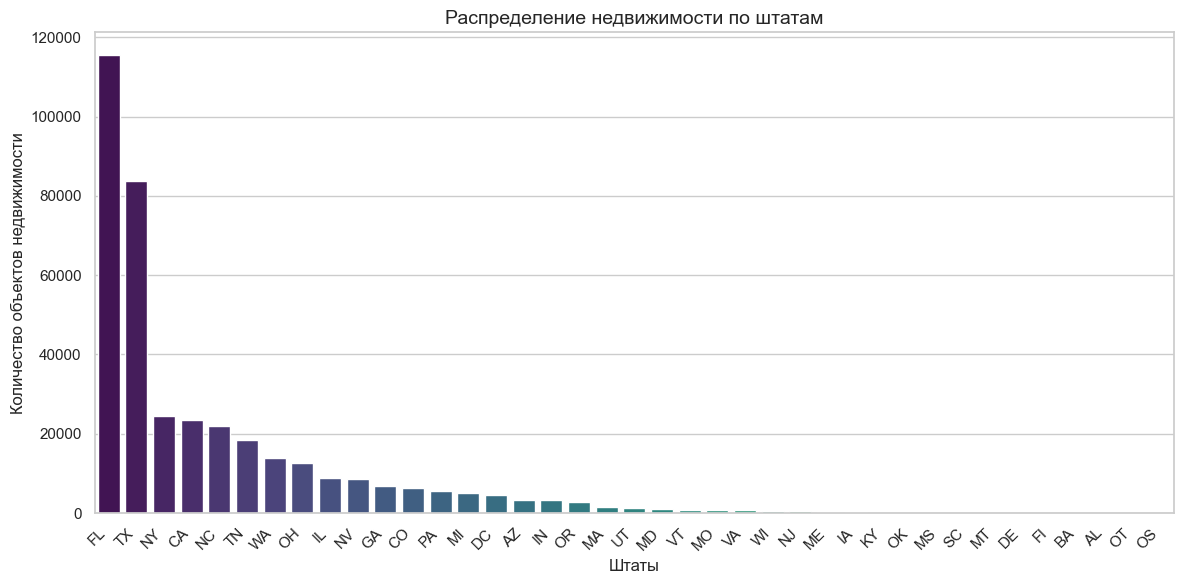

–ì—Ä–∞—Ñ–∏–∫ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ —Ñ–∞–π–ª state_distribution_barplot.png


In [86]:

# –£—Å—Ç–∞–Ω–æ–≤–∫–∞ —Å—Ç–∏–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
sns.set(style="whitegrid")
# –ü—Ä–æ–≤–µ—Ä–∫–∞ –Ω–∞–ª–∏—á–∏—è –Ω—É–∂–Ω–æ–≥–æ —Å—Ç–æ–ª–±—Ü–∞
if 'state' not in df.columns:
    raise ValueError("–í —Ñ–∞–π–ª–µ –æ—Ç—Å—É—Ç—Å—Ç–≤—É–µ—Ç —Å—Ç–æ–ª–±–µ—Ü 'state'.")

# –ü–æ–¥—Å—á–µ—Ç –∫–æ–ª–∏—á–µ—Å—Ç–≤–∞ –æ–±—ä–µ–∫—Ç–æ–≤ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ –ø–æ —à—Ç–∞—Ç–∞–º
state_counts = df['state'].value_counts().sort_values(ascending=False)

# –ü–æ—Å—Ç—Ä–æ–µ–Ω–∏–µ —Å—Ç–æ–ª–±—á–∞—Ç–æ–π –¥–∏–∞–≥—Ä–∞–º–º—ã
plt.figure(figsize=(12, 6))
sns.barplot(x=state_counts.index, y=state_counts.values, palette="viridis")
plt.xticks(rotation=45, ha='right')
plt.xlabel("–®—Ç–∞—Ç—ã", fontsize=12)
plt.ylabel("–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –æ–±—ä–µ–∫—Ç–æ–≤ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏", fontsize=12)
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ –ø–æ —à—Ç–∞—Ç–∞–º", fontsize=14)
plt.tight_layout()

# –°–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ –≥—Ä–∞—Ñ–∏–∫–∞
output_path = "/mnt/data/state_distribution_barplot.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)
plt.savefig(output_path)
plt.show()
plt.close()

print("–ì—Ä–∞—Ñ–∏–∫ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω –≤ —Ñ–∞–π–ª state_distribution_barplot.png")


–ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø–æ—Ç–µ–Ω—Ü–∏–∞–ª—å–Ω—ã—Ö —Å–¥–µ–ª–æ —Å –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç—å—é –≤ —à—Ç–∞—Ç–∞—Ö FL (–§–ª–æ—Ä–∏–¥–∞) –∏ TX (–¢–µ—Ö–∞—Å) –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ –ø—Ä–∏–≤–æ—Å—Ö–æ–¥—è—Ç –≤—Å–µ –¥—Ä—É–≥–∏–µ —à—Ç–∞—Ç—ã.

C:\Users\Asus\AppData\Local\Temp\ipykernel_21368\510604574.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='state', y='target', data=median_prices, palette='viridis')


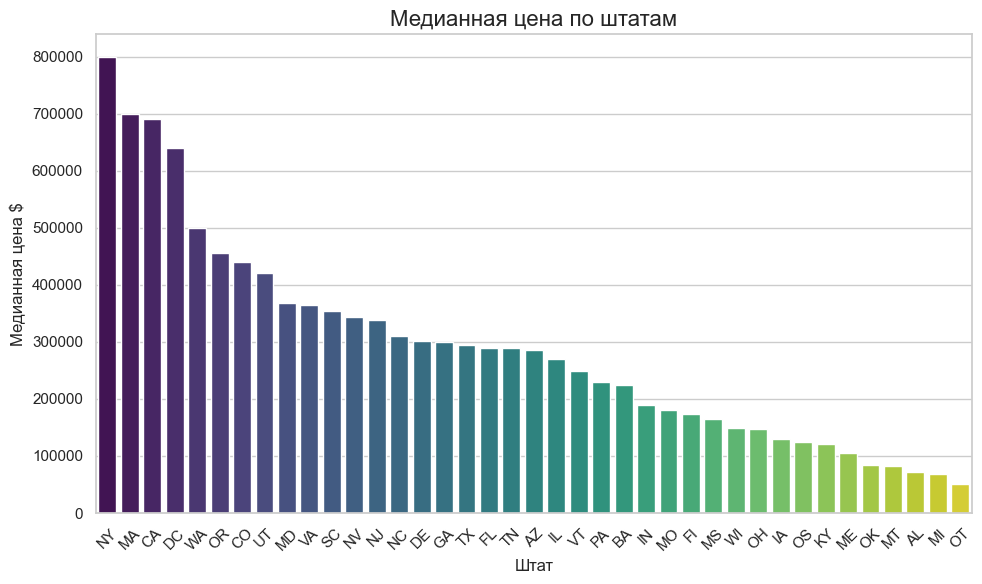

In [87]:
#
# Set seaborn style
sns.set(style="whitegrid")

# Sample data creation for demonstration (replace with actual df if available)
##data = {
##    'state': ['CA', 'CA', 'TX', 'TX', 'NY', 'NY', 'FL', 'FL', 'FL'],
##    'price': [350000, 420000, 250000, 270000, 500000, 520000, 300000, 310000, 320000]
##}
##df = pd.DataFrame(data)
#
# Calculate median price per state
median_prices = df.groupby('state')['target'].median().reset_index()

# Sort by median price for better visualization
median_prices = median_prices.sort_values(by='target', ascending=False)

# Create output directory if it doesn't exist
output_dir = '/mnt/data'
os.makedirs(output_dir, exist_ok=True)

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(x='state', y='target', data=median_prices, palette='viridis')
plt.title('–ú–µ–¥–∏–∞–Ω–Ω–∞—è —Ü–µ–Ω–∞ –ø–æ —à—Ç–∞—Ç–∞–º', fontsize=16)
plt.xlabel('–®—Ç–∞—Ç', fontsize=12)
plt.ylabel('–ú–µ–¥–∏–∞–Ω–Ω–∞—è —Ü–µ–Ω–∞ $', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()

# Save plot
plot_path = os.path.join(output_dir, 'median_price_by_state.png')
plt.savefig(plot_path)
plt.show()
plt.close()

–ü–æ —Ü–µ–Ω–µ –ª–∏–¥–∏—Ä—É–µ—Ç —à—Ç–∞—Ç –ù—å—é-–ô–æ—Ä–∫, —à—Ç–∞—Ç—ã, –∫–¥–µ –±–æ–ª—å—à–µ –≤—Å–µ–≥–æ –ø—Ä–æ–¥–∞–∂ (FL, TX) –ø–æ —Ü–µ–Ω–µ –≤ –Ω–µ–¥–æ—Ä–æ–≥–æ–º —Å–µ–≥–º–µ–Ω—Ç–µ. –í–æ–∑–º–æ–∂–Ω–æ —Ç–∞–º —Å—Ç—Ä–æ–∏—Ç–µ–ª—å–Ω—ã–π –±—É–º –∏ –º–∏–≥—Ä–∞—Ü–∏—è –≤ —ç—Ç–∏ —à—Ç–∞—Ç—ã.

In [88]:
median_prices.value_counts(dropna=False).to_csv('state_median_price.csv')
display(median_prices.value_counts(dropna=False))

state  target  
AL     72000.0     1
OT     50000.0     1
NJ     339000.0    1
NV     343690.0    1
NY     799000.0    1
OH     147000.0    1
OK     85000.0     1
OR     454900.0    1
OS     125000.0    1
PA     229900.0    1
MT     82900.0     1
SC     354495.0    1
TN     289000.0    1
TX     294999.0    1
UT     419900.0    1
VA     364900.0    1
VT     249000.0    1
WA     499000.0    1
NC     309765.0    1
MS     165000.0    1
AZ     285000.0    1
GA     300000.0    1
BA     225000.0    1
CA     690990.0    1
CO     439900.0    1
DC     639990.0    1
DE     301300.0    1
FL     289900.0    1
Fl     174000.0    1
IA     129900.0    1
MO     179900.0    1
IL     269994.5    1
IN     190000.0    1
KY     121450.0    1
MA     699250.0    1
MD     367697.0    1
ME     105750.0    1
MI     69000.0     1
WI     149450.0    1
Name: count, dtype: int64

In [89]:
df = df.drop(columns=['city', 'zipcode'], errors='ignore')

### ---------------------------    –≤—Ç–æ—Ä–æ–π –ø—Ä–æ—Ö–æ–¥ –ø–æ –ø—Ä–∏–∑–Ω–∞–∫–∞–º

–ó–∞–ø–æ–ª–Ω—è–µ–º –æ—Å—Ç–∞–≤—à–∏–µ—Å—è –ø—Ä–æ–ø—É—Å–∫–∏ '**propertyType**' –Ω–∞ '**single family**', –∫–∞–∫ –Ω–∞ —Å–∞–º—ã–π –ø–æ–ø—É–ª—è—Ä–Ω—ã–π –ø—Ä–∏–∑–Ω–∞–∫

In [90]:
df['propertyType'] = df['propertyType'].fillna('single family')


–ó–∞–ø–æ–ª–Ω—è–µ–º –æ—Å—Ç–∞–≤—à–∏–µ—Å—è –ø—Ä–æ–ø—É—Å–∫–∏ '**fireplace_count**' –Ω–∞ 0, –∫–∞–∫ –Ω–∞ —Å–∞–º—ã–π –ø–æ–ø—É–ª—è—Ä–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–π

In [91]:
df['fireplace_count'] = df['fireplace_count'].fillna(0.0)
df['fireplace_count'] = df['fireplace_count'].astype(int) # –ø—Ä–µ–≤—Ä–∞—â–∞–µ–º –≤ —Ü–µ–ª—ã–π —Ç–∏–ø



—Ç–∞–∫–∂–µ –∑–∞–º–µ–Ω—è–µ—Ç –æ—Å—Ç–∞–≤—à–µ–µ—Å—è –Ω–µ–±–æ–ª—å—à–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –ø—Ä–æ–ø—É—Å–∫–æ–≤ '**status_clean**','**zipcode_encoded**','**stories_clean**'

In [92]:
df['status_clean'] = df['status_clean'].fillna('for sale')
#

In [93]:
median_zipcode = df['zipcode_encoded'].median()
df['zipcode_encoded'] = df['zipcode_encoded'].fillna(median_zipcode)
df['zipcode_encoded'] = df['zipcode_encoded'].round(0).astype(int)

In [94]:
df['stories_clean'] = df['stories_clean'].fillna('1 story')


In [95]:
# —Å–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –ø—Ä–æ–ø—É—Å–∫–æ–≤
#
missing_info = []
#
for col in df.columns:
    non_nulls = df[col].notna().sum()
    nulls = df[col].isna().sum()
    dtype = str(df[col].dtype)
    missing_info.append((col, dtype, non_nulls, nulls))

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –ø—Ä–æ–ø—É—Å–∫–æ–≤
missing_info.sort(key=lambda x: x[3], reverse=True)

for col, dtype, non_nulls, nulls in missing_info:
    print(f"{col:25} | dtype: {dtype:<10} | non-null: {non_nulls:<8} | nulls: {nulls}")

has_pool                  | dtype: float64    | non-null: 377135   | nulls: 50
baths                     | dtype: int32      | non-null: 377185   | nulls: 0
sqft                      | dtype: float64    | non-null: 377185   | nulls: 0
beds                      | dtype: int32      | non-null: 377185   | nulls: 0
state                     | dtype: object     | non-null: 377185   | nulls: 0
target                    | dtype: float64    | non-null: 377185   | nulls: 0
propertyType              | dtype: object     | non-null: 377185   | nulls: 0
fireplace_count           | dtype: int32      | non-null: 377185   | nulls: 0
status_clean              | dtype: object     | non-null: 377185   | nulls: 0
stories_clean             | dtype: object     | non-null: 377185   | nulls: 0
home_Year_built           | dtype: float64    | non-null: 377185   | nulls: 0
lotsize_sqft              | dtype: float64    | non-null: 377185   | nulls: 0
zipcode_prefix            | dtype: object     | non-null: 37718

–≤ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ —Ä–∞–±–æ—Ç—ã –Ω–∞–¥ –≤—Å–µ–º–∏ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏ –ø–æ–ª—É—á–∏–ª–∏ —á–∏—Å—Ç—ã–π dataframe –±–µ–∑ –ø—Ä–æ–ø—É—Å–∫–æ–≤, –≤ –∫–æ—Ç–æ—Ä–æ–º —Å–æ—Ö—Ä–∞–Ω–∏–ª–∏ –ø–æ–∫–∞ –∏—Å—Ö–æ–¥–Ω–æ–µ –∑–Ω–∞—á–µ–Ω–∏–µ —Å—Ç—Ä–æ–∫.

####  ---------------  –≤—ã–±—Ä–æ—Å—ã

–ª–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä—É–µ–º –≤—Å–µ —á—Ç–æ —Å–≤—è–∑–∞–Ω–æ —Å target

In [96]:
#
# –õ–æ–≥–∞—Ä–∏—Ñ–º–∏—Ä—É–µ–º target
df['target_log'] = np.log1p(df['target'])  # log1p –±–µ–∑–æ–ø–∞—Å–µ–Ω –¥–ª—è –Ω—É–ª—è
df['zipcode_encod_log'] = np.log1p(df['zipcode_encoded'])  # log1p –±–µ–∑–æ–ø–∞—Å–µ–Ω –¥–ª—è –Ω—É–ª—è
df['city_encod_log'] = np.log1p(df['city_encoded'])  # log1p –±–µ–∑–æ–ø–∞—Å–µ–Ω –¥–ª—è –Ω—É–ª—è
#
df = df.drop(columns=['target', 'city_encoded', 'zipcode_encoded'], errors='ignore')
#


–º–æ–¥—É–ª—å –¥–ª—è —É–¥–∞–ª–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤ –æ—Ç –≤—Å–µ—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—è–º

In [97]:
#
def remove_outliers_percentile(df, lower=0.01, upper=0.99):
    """
    –£–¥–∞–ª—è–µ—Ç –≤—ã–±—Ä–æ—Å—ã –∏–∑ —á–∏—Å–ª–æ–≤—ã—Ö —Å—Ç–æ–ª–±—Ü–æ–≤ DataFrame –º—è–≥–∫–æ–π —Ñ–∏–ª—å—Ç—Ä–∞—Ü–∏–µ–π –ø–æ –ø—Ä–æ—Ü–µ–Ω—Ç–∏–ª—è–º.
    """
    df_clean = df.copy()
    numeric_cols = df_clean.select_dtypes(include=['int64', 'float64', 'int32']).columns

    for col in numeric_cols:
        low = df_clean[col].quantile(lower)
        high = df_clean[col].quantile(upper)
        df_clean = df_clean[(df_clean[col] >= low) & (df_clean[col] <= high)]

    return df_clean
df_cleaned = remove_outliers_percentile(df, lower=0.005, upper=0.995)
print(f"–†–∞–∑–º–µ—Ä –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤: {df.shape}, –ø–æ—Å–ª–µ: {df_cleaned.shape}")


–†–∞–∑–º–µ—Ä –¥–æ —É–¥–∞–ª–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤: (377185, 22), –ø–æ—Å–ª–µ: (350320, 22)


–¥–æ–ø–æ–ª–Ω–∏—Ç–µ–ª—å–Ω–æ–µ —É–¥–∞–ª–µ–Ω–∏–µ –≤—ã–±—Ä–æ—Å–æ–≤ 

–û—á–∏—â–∞–µ–º –æ—Å–Ω–æ–≤–Ω–æ–π –¥–∞—Ç–∞—Ñ—Ä–µ–π–º –æ—Ç –≤—ã–±—Ä–æ—Å–æ–≤ '**target_log**' > 14.7 –∏  '**target_log**' < 10.8  , —Ç–æ–µ—Å—Ç—å —É–¥–∞–ª—è–µ–º –æ—á–µ–Ω—å –¥–æ—Ä–æ–≥—É—é  
–∏ –æ—á–µ–Ω—å –¥–µ—à–µ–≤—É—é –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç—å (–≤ –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–º –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏–∏)

In [98]:
#
df_cleaned = df_cleaned[(df_cleaned['target_log'] <= 14.7) & (df_cleaned['target_log'] >= 10.8)]
#




–≤—ã–≤–æ–¥ –∏–Ω—Ñ–æ—Ä–º–∞—Ü–∏–∏ –æ —á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–∞—Ö –¥–æ –∏ –ø–æ—Å–ª–µ —É–¥–∞–ª–µ–Ω–∏—è –≤—ã–±—Ä–æ—Å–æ–≤

In [99]:
display(df.describe())
display(df_cleaned.describe())

baths          sqft           beds       has_pool  \
count  377185.000000  3.771850e+05  377185.000000  377135.000000   
mean        2.465066  6.285750e+03       3.239911       0.238578   
std         1.162727  1.494365e+06       1.084356       0.426215   
min         0.000000  1.000000e+00       0.000000       0.000000   
25%         2.000000  1.370000e+03       3.000000       0.000000   
50%         2.000000  1.981000e+03       3.000000       0.000000   
75%         3.000000  3.005800e+03       4.000000       0.000000   
max        10.000000  7.959794e+08      10.000000       1.000000   

       fireplace_count  home_Year_built  lotsize_sqft  age_since_remodel  \
count    377185.000000    377185.000000  3.771850e+05      377185.000000   
mean          0.068765      1980.262138  9.873484e+04          42.797610   
std           0.323600        30.802647  7.830557e+06          60.412944   
min           0.000000      1800.000000  0.000000e+00           0.000000   
25%           0.000000      1962.000000  6.250000e+03          19.000000   
50%           0.000000      1985.000000  8.276000e+03          38.000000   
75%           0.000000      2005.000000  1.117900e+04          55.000000   
max          12.000000      2025.000000  2.147484e+09        2025.000000   

       school_rating_mean  school_min_dist     target_log  zipcode_encod_log  \
count       377185.000000    377185.000000  377185.000000      377185.000000   
mean             6.860076         1.173342      12.657535          12.979386   
std              1.676516         5.318316       1.193972           0.834773   
min              1.000000         0.000000       0.693147           8.006701   
25%              6.000000         0.370000      12.149508          12.478501   
50%              7.000000         0.690000      12.706548          12.918814   
75%              8.000000         1.300000      13.287710          13.404115   
max             10.000000      1590.380000      19.088510          17.223766   

       city_encod_log  
count   377185.000000  
mean        13.079671  
std          0.713212  
min          8.006701  
25%         12.651992  
50%         13.072038  
75%         13.444728  
max         17.909855

baths           sqft           beds       has_pool  \
count  322125.000000  322125.000000  322125.000000  322125.000000   
mean        2.423885    2128.024437       3.197818       0.246817   
std         0.950454    1075.699722       0.964409       0.431160   
min         0.000000     500.000000       0.000000       0.000000   
25%         2.000000    1344.000000       3.000000       0.000000   
50%         2.000000    1904.000000       3.000000       0.000000   
75%         3.000000    2800.000000       4.000000       0.000000   
max         8.000000   12628.000000       8.000000       1.000000   

       fireplace_count  home_Year_built  lotsize_sqft  age_since_remodel  \
count    322125.000000    322125.000000  3.221250e+05      322125.000000   
mean          0.065006      1981.018917  2.232124e+04          40.700554   
std           0.273166        29.683586  7.342376e+04          27.812825   
min           0.000000      1890.000000  4.790000e+02           5.000000   
25%           0.000000      1963.000000  6.300000e+03          19.000000   
50%           0.000000      1985.000000  8.276000e+03          38.000000   
75%           0.000000      2005.000000  1.089000e+04          55.000000   
max           2.000000      2020.000000  1.252786e+06         126.000000   

       school_rating_mean  school_min_dist     target_log  zipcode_encod_log  \
count       322125.000000    322125.000000  322125.000000      322125.000000   
mean             6.871921         1.067676      12.743424          12.987550   
std              1.648234         1.218740       0.771482           0.696046   
min              2.000000         0.060000      10.800759          10.780185   
25%              6.200000         0.380000      12.254391          12.540203   
50%              7.000000         0.690000      12.733463          12.932166   
75%              8.000000         1.300000      13.233907          13.360116   
max              9.800000        10.300000      14.699469          15.531939   

       city_encod_log  
count   322125.000000  
mean        13.083040  
std          0.612256  
min         11.128527  
25%         12.651992  
50%         13.072038  
75%         13.444728  
max         15.233782

–≤ –≤—ã–±—Ä–æ—Å—ã –ø–æ—â–ª–æ –¥–æ–≤–æ–ª—å–Ω–æ –∑–∞–º–µ—Ç–Ω–æ–µ –∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å—Ç—Ä–æ–∫ –∏–∑ df (~ 50000). –í –∏—Ç–æ–≥–µ –æ–ø–µ—Ä–∏—Ä—É–µ–º —Ç–µ–ø–µ—Ä—å **df_cleaned**

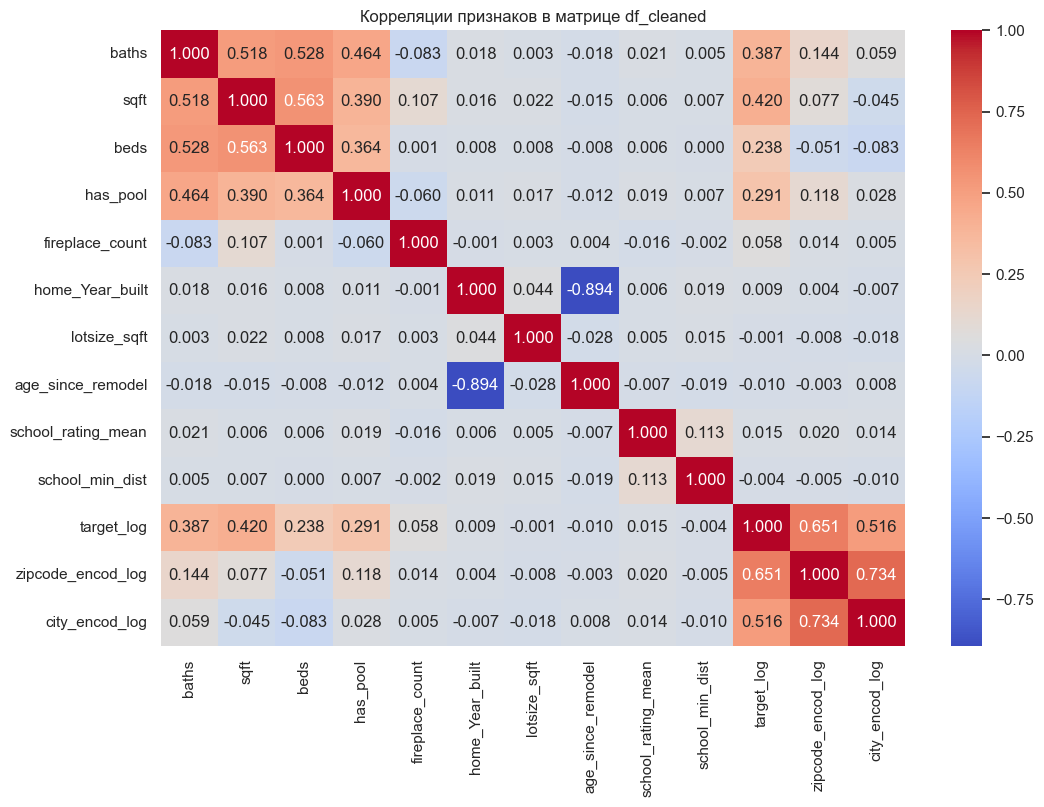

In [100]:
#
# –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞
corr_matrix = df_cleaned.corr(method='spearman',numeric_only=True)

# –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".3f")
plt.title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –≤ –º–∞—Ç—Ä–∏—Ü–µ df_cleaned")
plt.show()


–≤ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–æ–Ω–Ω–æ–π –º–∞—Ç—Ä–∏—Ü–µ –Ω–∞—Å –∏–Ω—Ç–µ—Ä–∏—Å—É–µ—Ç –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –ª–æ–≥–∞—Ä–∏—Ñ–º–∞ —Ü–µ–Ω—ã '**target_log**'. –ú—ã –≤–∏–¥–∏–º, —á—Ç–æ –ø–æ –≤—Å–µ–º —á–∏—Å–ª–æ–≤—ã–º –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–º –Ω–∞–±–ª—é–¥–∞–µ—Ç—Å—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è ( –∏–ª–∏ –∞–Ω—Ç–∏–∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è)  
—Ä–∞–∑–ª–∏—á–Ω–æ–π —Å—Ç–µ–ø–µ–Ω–∏. –û—Å–Ω–æ–≤–Ω—ã–µ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ ( –≤ –ø–æ—Ä—è–¥–∫–µ —É–±—ã–≤–∞–Ω–∏—è –∫–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç–∞ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏): '**zipcode_encoded_log**', '**city_encoded_log**', '**sqft**', '**baths**, '**has_pool**', '**beds**',  
—á—Ç–æ, –≤–ø–æ–ª–Ω–µ –æ—â—É—Ç–∏–º–æ –∑–∞–∫–æ–Ω–æ–º–µ—Ä–Ω–æ.

–ø—Ä–æ–≥—Ä–∞–º–º–∞ –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è –Ω–µ—á–∏—Å–ª–æ–≤—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤

In [101]:
#
def encode_categorical(df, target_column):
    df_encoded = df.copy()
    cat_cols = df.select_dtypes(include='object').columns

    # –†–∞–∑–¥–µ–ª–∏–º –ø—Ä–∏–∑–Ω–∞–∫–∏ –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É —É–Ω–∏–∫–∞–ª—å–Ω—ã—Ö –∑–Ω–∞—á–µ–Ω–∏–π
    one_hot_cols = []
    target_enc_cols = []
    label_enc_cols = []

    for col in cat_cols:
        n_unique = df[col].nunique()
        if n_unique <= 10:
            one_hot_cols.append(col)
        elif n_unique <= 50:
            target_enc_cols.append(col)
        else:
            label_enc_cols.append(col)

    print("üîπ One-Hot Encoding:", one_hot_cols)
    print("üîπ Target Encoding:", target_enc_cols)
    print("üîπ Label Encoding:", label_enc_cols)

    # –ü—Ä–∏–º–µ–Ω–∏–º One-Hot Encoding
    if one_hot_cols:
        df_encoded = pd.get_dummies(df_encoded, columns=one_hot_cols, drop_first=True)

    # –ü—Ä–∏–º–µ–Ω–∏–º Target Encoding
    if target_enc_cols:
        te = TargetEncoder(cols=target_enc_cols)
        df_encoded[target_enc_cols] = te.fit_transform(df_encoded[target_enc_cols], df_encoded[target_column])

    # –ü—Ä–∏–º–µ–Ω–∏–º Label Encoding
    for col in label_enc_cols:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    return df_encoded
#
#
df_encoded = encode_categorical(df_cleaned, target_column='target_log') # —Ñ–∏–Ω–∞–ª—å–Ω–∞—è –∑–∞–∫–æ–¥–∏—Ä–æ–≤–∞–Ω–Ω–∞—è –º–∞—Ç—Ä–∏—Ü–∞
#


üîπ One-Hot Encoding: ['propertyType', 'status_clean', 'heating_group', 'cooling_group']
üîπ Target Encoding: ['state', 'stories_clean', 'parking_group']
üîπ Label Encoding: ['zipcode_prefix', 'city_grouped']


–≤—ã–≤–æ–¥–∏–º —Ñ–∏–Ω–∞–ª—å–Ω—ã–π  **df_encoded** –ø–æ—Å–ª–µ –æ—á–∏—Å—Ç–∫–∏ –∏ –∫–æ–¥–∏—Ä–æ–≤–∞–Ω–∏—è.

In [102]:
# —Å–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –ø—Ä–æ–ø—É—Å–∫–æ–≤
#
missing_info = []
#
for col in df_encoded.columns:
    non_nulls = df_encoded[col].notna().sum()
    nulls = df_encoded[col].isna().sum()
    dtype = str(df_encoded[col].dtype)
    missing_info.append((col, dtype, non_nulls, nulls))

# –°–æ—Ä—Ç–∏—Ä—É–µ–º –ø–æ –∫–æ–ª–∏—á–µ—Å—Ç–≤—É –ø—Ä–æ–ø—É—Å–∫–æ–≤
missing_info.sort(key=lambda x: x[3], reverse=True)

for col, dtype, non_nulls, nulls in missing_info:
    print(f"{col:25} | dtype: {dtype:<10} | non-null: {non_nulls:<8} | nulls: {nulls}")

baths                     | dtype: int32      | non-null: 322125   | nulls: 0
sqft                      | dtype: float64    | non-null: 322125   | nulls: 0
beds                      | dtype: int32      | non-null: 322125   | nulls: 0
state                     | dtype: float64    | non-null: 322125   | nulls: 0
has_pool                  | dtype: float64    | non-null: 322125   | nulls: 0
fireplace_count           | dtype: int32      | non-null: 322125   | nulls: 0
stories_clean             | dtype: float64    | non-null: 322125   | nulls: 0
home_Year_built           | dtype: float64    | non-null: 322125   | nulls: 0
lotsize_sqft              | dtype: float64    | non-null: 322125   | nulls: 0
zipcode_prefix            | dtype: int32      | non-null: 322125   | nulls: 0
city_grouped              | dtype: int32      | non-null: 322125   | nulls: 0
age_since_remodel         | dtype: float64    | non-null: 322125   | nulls: 0
parking_group             | dtype: float64    | non-null: 322125

###  -------------------    **ML –º–æ–¥–µ–ª—å –ø—Ä–æ–≥–Ω–æ–∑–∞ —Ü–µ–Ω—ã ('target')**

In [103]:
#
X = df_encoded.drop(columns='target_log')
y = df_encoded['target_log']
#
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#

### **–ª–∏–Ω–µ–π–Ω–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è**

In [104]:
#
model = LinearRegression()
model.fit(X_train, y_train)
#

LinearRegression()

In [105]:
#
y_pred = model.predict(X_test)
#
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = mean_squared_error(y_test, y_pred, squared=False)
#
# –ü–µ—Ä–µ–≤–æ–¥–∏–º –∏–∑ –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–π —à–∫–∞–ª—ã –æ–±—Ä–∞—Ç–Ω–æ –≤ –¥–æ–ª–ª–∞—Ä—ã
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)
#
mae_dollars  = mean_absolute_error(y_test_dollars, y_pred_dollars)
rmse_dollars = mean_squared_error(y_test_dollars, y_pred_dollars, squared=False)
#
print(f"üìà MAE: {mean_absolute_error(y_test, y_pred):.3f} ({mae_dollars:.1f} $)")
print(f"üìâ RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f} ({rmse_dollars:.1f} $)")
print(f"üìä R¬≤: {r2_score(y_test, y_pred):.3f}")
#



üìà MAE: 0.349 (157383.0 $)
üìâ RMSE: 0.479 (290115.9 $)
üìä R¬≤: 0.617


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


–ø—Ä–æ—Å—Ç–∞—è –ª–∏–Ω–µ–π–Ω–∞—è —Ä–µ–≥—Ä–µ—Å—Å–∏—è –¥–∞–ª–∞ –Ω–µ –æ—á–µ–Ω—å —Ç–æ –≤—ã—Å–æ–∫–∏–µ –º–µ—Ç—Ä–∏–∫–∏. **R2~0.62** –æ–∑–Ω–∞—á–∞–µ—Ç, —á—Ç–æ –º–æ–¥–µ–ª—å –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏ –æ–±—ä—è—Å–Ω—è–µ—Ç 62% –¥–∏—Å–ø–µ—Ä—Å–∏–∏ —Ç–µ—Å—Ç–æ–≤—ã—Ö –¥–∞–Ω–Ω—ã—Ö,**MAE ~ 157000 $**
—ç—Ç–æ —Å—Ä–µ–¥–Ω–µ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ y_pred –æ—Ç y_test –Ω–∞ –≤—Å–µ–º —Ü–µ–Ω–æ–≤–æ–º –¥–∏–∞–ø–∞–∑–æ–Ω–µ, —á—Ç–æ –Ω–µ —Ç–∞–∫ —Ç–æ –ø–ª–æ—Ö–æ, —É—á–∏—Ç—ã–≤–∞—è —á—Ç–æ –¥–∏–∞–ø–∞–∑–æ–Ω —Ü–µ–Ω 300 000 - 2 000 000 –¥–æ–ª–ª–∞—Ä–æ–≤ –∏ –≤—ã—à–µ. **RMSE ~ 290 000 –¥–æ–ª–ª–∞—Ä–æ–≤** - —ç—Ç–æ —Å—Ä–µ–¥–Ω–µ–∫–≤–∞–¥—Ä–∞—Ç–∏—á–µ—Å–∫–æ–µ –æ—Ç–∫–ª–æ–Ω–µ–Ω–∏–µ - –æ–Ω–æ  
–∑–∞–∫–æ–Ω–æ–º–µ—Ä–Ω–æ —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –≤—ã—à–µ.


### –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏–π –ø–æ–¥–±–æ—Ä –Ω–∞—á–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ **CatBoosting**

In [106]:
#
# –ü–∞—Ä–∞–º–µ—Ç—Ä—ã –¥–ª—è —Å–ª—É—á–∞–π–Ω–æ–≥–æ –ø–µ—Ä–µ–±–æ—Ä–∞
#
param_dist = {
    'iterations': [300, 500, 700, 900, 1000],
    'depth': [4, 5, 6, 7, 8, 9, 10],
    'learning_rate': [0.02, 0.03, 0.05, 0.07, 0.1, 0.15],
    'l2_leaf_reg': [1, 3, 5, 7, 9],
    'border_count': [32, 64, 128],
    'bagging_temperature': [0, 0.5, 1, 2, 5]
}

# –ò–Ω–∏—Ü–∏–∞–ª–∏–∑–∞—Ü–∏—è –º–æ–¥–µ–ª–∏
catboost_base = CatBoostRegressor(
    verbose=0,
    random_state=42
)

# RandomizedSearchCV
search = RandomizedSearchCV(
    estimator=catboost_base,
    param_distributions=param_dist,
    n_iter=30,              # –ö–æ–ª-–≤–æ —Å–ª—É—á–∞–π–Ω—ã—Ö –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π
    scoring='r2',
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# –û–±—É—á–µ–Ω–∏–µ
search.fit(X_train, y_train)

# –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
best_model = search.best_estimator_
y_pred = best_model.predict(X_test)

# –ú–µ—Ç—Ä–∏–∫–∏
print("\n‚úÖ –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã:", search.best_params_)
print("üìà R¬≤ –Ω–∞ –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏:", search.best_score_)
print("üìâ MAE:", mean_absolute_error(y_test, y_pred))
print("üìâ RMSE:", mean_squared_error(y_test, y_pred, squared=False))
print("üìä R¬≤ –Ω–∞ —Ç–µ—Å—Ç–µ:", r2_score(y_test, y_pred))


Fitting 3 folds for each of 30 candidates, totalling 90 fits

‚úÖ –õ—É—á—à–∏–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã: {'learning_rate': 0.15, 'l2_leaf_reg': 3, 'iterations': 900, 'depth': 9, 'border_count': 64, 'bagging_temperature': 0.5}
üìà R¬≤ –Ω–∞ –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.750607799901302
üìâ MAE: 0.26146791058568875
üìâ RMSE: 0.3827059601861202
üìä R¬≤ –Ω–∞ —Ç–µ—Å—Ç–µ: 0.7549218522282966


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


–Ω–∞ –ª—É—á—à–∏—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–∞—Ö –º–æ–¥–µ–ª—å  **CatBoosting** –ø–æ–∫–∞–∑–∞–ª–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–æ–µ –ø—Ä–µ–≤–æ—Å—Ö–æ–¥—Å—Ç–≤–æ –Ω–∞–¥ **–ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–µ–π**. –ó–Ω–∞—á–µ–Ω–∏–µ **R2 ~ 0.751** –Ω–∞ –∫—Ä–æ—Å—Å –≤–∞–ª–∏–¥–∞—Ü–∏–∏ –∏ **R2 ~0.755** –Ω–∞ —Ç–µ—Å—Ç–æ–≤—ã—Ö  
–∑–Ω–∞—á–µ–Ω–∏—è—Ö y_test –≤–µ—Å—å–º–∞ –ø–æ—Ö–æ–∂–∏, —á—Ç–æ –≥–æ–≤–æ—Ä–∏—Ç –æ–± –æ—Ç—Å—É—Ç—Å—Ç–≤–∏–∏ –ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏—è. –û—á–µ–≤–∏–¥–Ω–æ, –º–µ—Ç—Ä–∏–∫–∏ Catboosting —Å—É—â–µ—Å—Ç–≤–µ–Ω–Ω–æ –ø—Ä–µ–≤–æ—Å—Ö–æ–¥—è—Ç –º–µ—Ç—Ä–∏–∫–∏ –ª–∏–Ω–µ–π–Ω–æ–π —Ä–µ–≥—Ä–µ—Å—Å–∏–∏.

### –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏ –ø–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º Catboosting

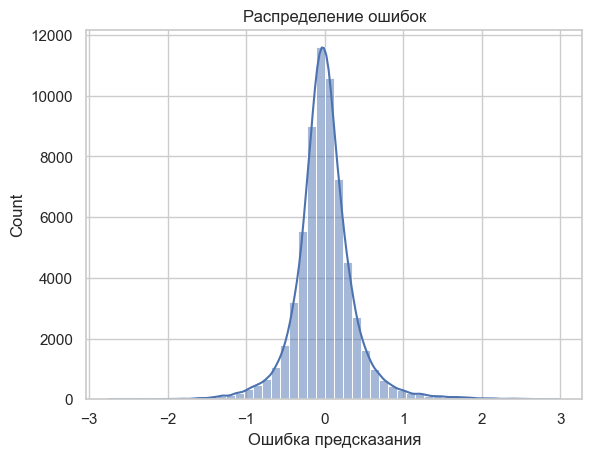

In [107]:
#
errors = y_test - y_pred
sns.histplot(errors, bins=50, kde=True)
plt.title("–†–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫")
plt.xlabel("–û—à–∏–±–∫–∞ –ø—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏—è")
plt.show()


—Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ –æ—à–∏–±–æ–∫ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª—è–µ—Ç —Å–æ–±–æ–π –∏–¥–µ–∞–ª—å–Ω–æ–µ –Ω–æ—Ä–º–∞–ª—å–Ω–æ–µ —Ä–∞—Å–ø—Ä–µ–¥–µ–ª–µ–Ω–∏–µ

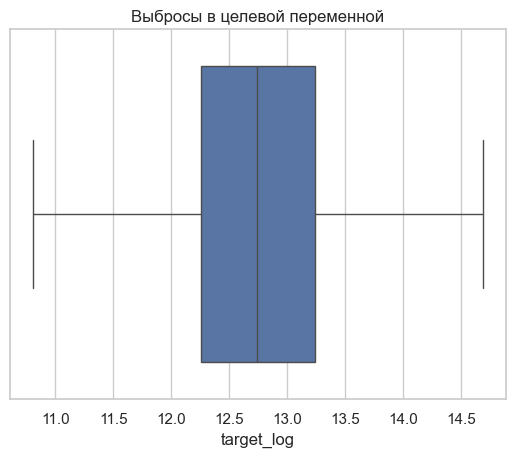

Q1 (25-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å): 12.25486757159303
Q3 (75-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å): 13.235693848424024
IQR (–º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã–π —Ä–∞–∑–º–∞—Ö): 0.9808262768309941
–ù–∏–∂–Ω–∏–π —É—Å (–ª–µ–≤–∞—è —á–µ—Ä—Ç–∞): 10.803669227477098
–í–µ—Ä—Ö–Ω–∏–π —É—Å (–ø—Ä–∞–≤–∞—è —á–µ—Ä—Ç–∞): 14.690979711984754


In [108]:
sns.boxplot(x=y_test)
plt.title("–í—ã–±—Ä–æ—Å—ã –≤ —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π")
plt.show()
#
# –†–∞—Å—á—ë—Ç –∫–≤–∞—Ä—Ç–∏–ª–µ–π
Q1 = y_test.quantile(0.25)
Q3 = y_test.quantile(0.75)
IQR = Q3 - Q1
#
print(f"Q1 (25-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å): {Q1}")
print(f"Q3 (75-–π –ø–µ—Ä—Ü–µ–Ω—Ç–∏–ª—å): {Q3}")
print(f"IQR (–º–µ–∂–∫–≤–∞—Ä—Ç–∏–ª—å–Ω—ã–π —Ä–∞–∑–º–∞—Ö): {IQR}")
#
lower_whisker = y_test[y_test >= Q1 - 1.5 * IQR].min()
upper_whisker = y_test[y_test <= Q3 + 1.5 * IQR].max()

print(f"–ù–∏–∂–Ω–∏–π —É—Å (–ª–µ–≤–∞—è —á–µ—Ä—Ç–∞): {lower_whisker}")
print(f"–í–µ—Ä—Ö–Ω–∏–π —É—Å (–ø—Ä–∞–≤–∞—è —á–µ—Ä—Ç–∞): {upper_whisker}")


–£–±—Ä–∞–ª–∏ –≤—Å–µ –≤—ã–±—Ä–æ—Å—ã —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π target_log —Å–ª–µ–≤–∞ –æ—Ç Q1 –∏ —Å–ø—Ä–∞–≤–∞ –æ—Ç –æ—Ç Q3

–ì—Ä–∞—Ñ–∏–∫–∏ –∑–∞–≤–∏—Å–∏–º–æ—Å—Ç–∏ –ø—Ä–æ–≥–Ω–æ–∑–∏—Ä—É–µ–º–æ–π —Ü–µ–Ω—ã y_pred –æ—Ç —Ä–µ–∞–ª—å–Ω–æ–π y_test

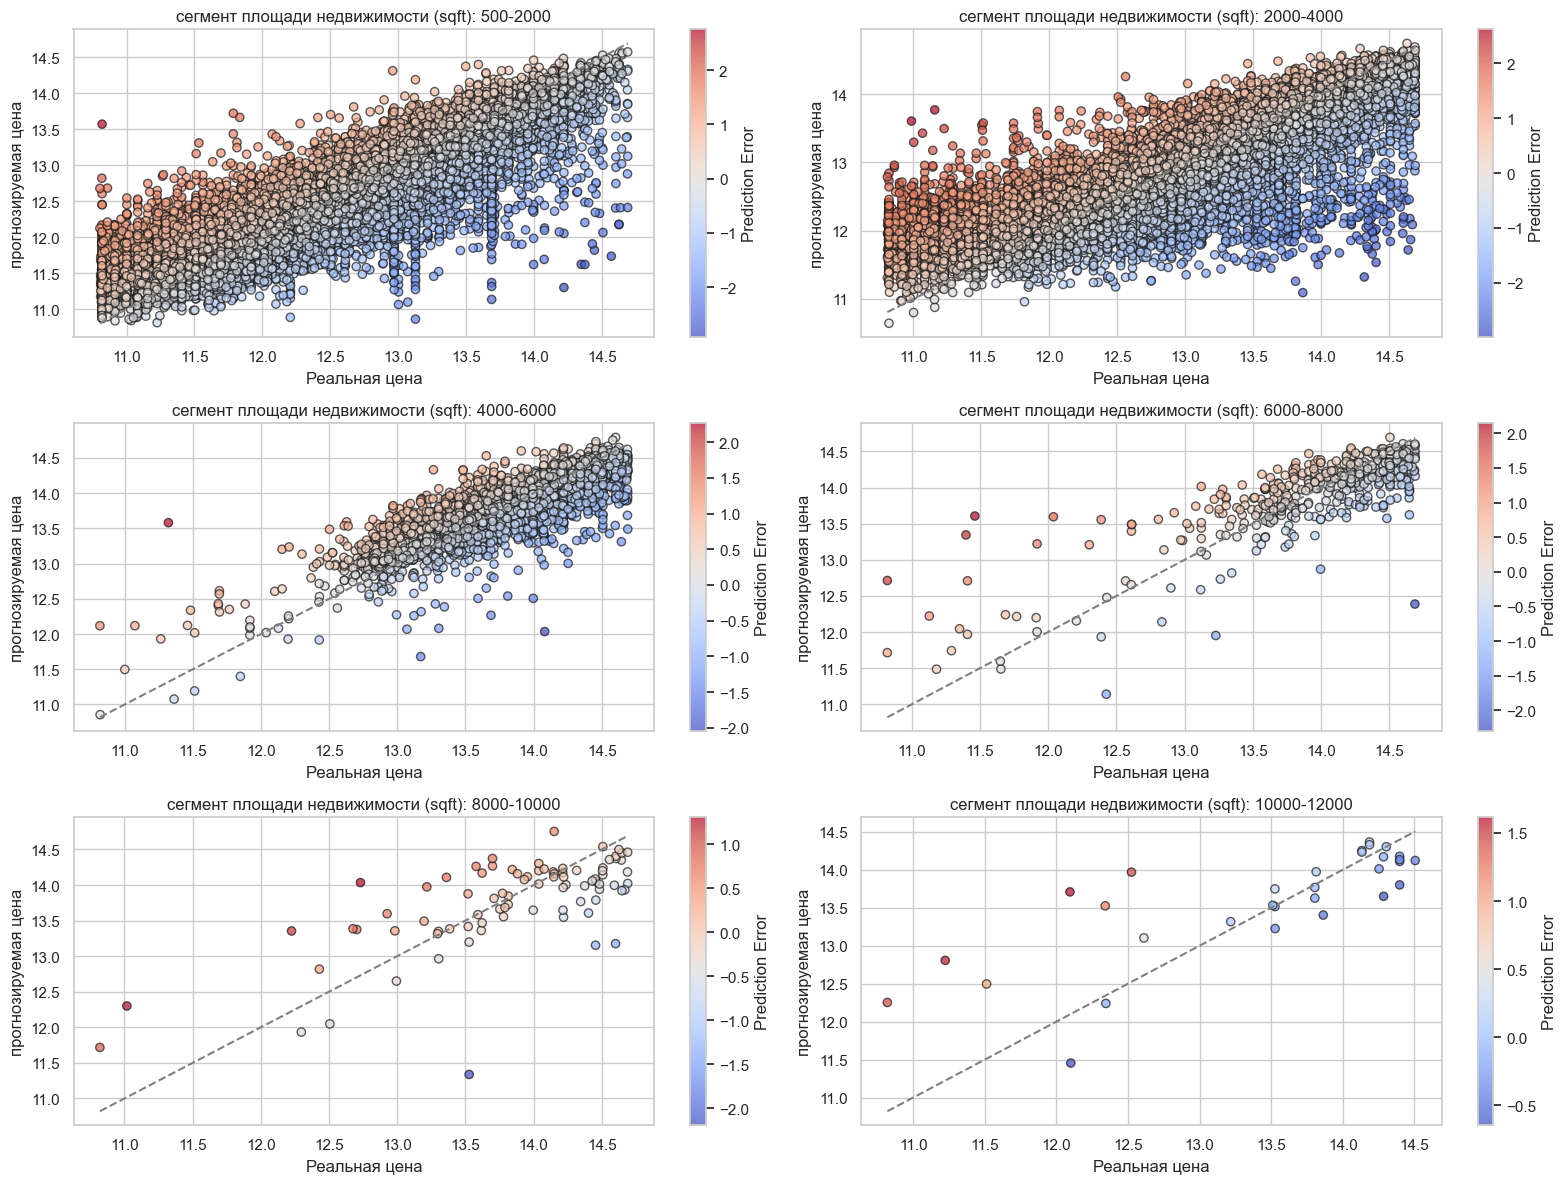

Scatter plots saved as prediction_error_scatterplots.png


In [109]:
# Create DataFrame
##df_plot = pd.DataFrame({
##    'y_test': y_test,
##    'y_pred': y_pred,
##    'sqft': df_encoded.loc[X_test.index, 'sqft']
##})
df_plot = pd.DataFrame({
    'y_test': y_test,
    'y_pred': y_pred,
    'sqft': X_test['sqft'].values  # –±–µ—Ä–µ–º –Ω–∞–ø—Ä—è–º—É—é –∏–∑ X_test
})
df_plot['error'] = df_plot['y_pred'] - df_plot['y_test']
#
# Define segments based on sqft
bins = [500, 2000, 4000, 6000, 8000, 10000, 12000]
labels = ['500-2000', '2000-4000', '4000-6000', '6000-8000', '8000-10000', '10000-12000']
df_plot['segment'] = pd.cut(df_plot['sqft'], bins=bins, labels=labels)

# Set up plot style
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
axes = axes.flatten()

# Create scatter plots for each segment
for i, segment in enumerate(labels):
    segment_data = df_plot[df_plot['segment'] == segment]
    scatter = axes[i].scatter(
        segment_data['y_test'],
        segment_data['y_pred'],
        c=segment_data['error'],
        cmap='coolwarm',
        edgecolor='k',
        alpha=0.7
    )
    axes[i].plot([segment_data['y_test'].min(), segment_data['y_test'].max()],
                 [segment_data['y_test'].min(), segment_data['y_test'].max()],
                 color='gray', linestyle='--')
    axes[i].set_title(f"—Å–µ–≥–º–µ–Ω—Ç –ø–ª–æ—â–∞–¥–∏ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ (sqft): {segment}")
    axes[i].set_xlabel("–†–µ–∞–ª—å–Ω–∞—è —Ü–µ–Ω–∞")
    axes[i].set_ylabel("–ø—Ä–æ–≥–Ω–æ–∑–∏—Ä—É–µ–º–∞—è —Ü–µ–Ω–∞")
    fig.colorbar(scatter, ax=axes[i], label='Prediction Error')

plt.tight_layout()
os.makedirs("/mnt/data", exist_ok=True)
plt.savefig("/mnt/data/prediction_error_scatterplots.png")
plt.show()
plt.close()
print("Scatter plots saved as prediction_error_scatterplots.png")


–ò–∑ –ø—Ä–∏–≤–µ–¥–µ–Ω–Ω—ã—Ö –≥—Ä–∞—Ñ–∏–∫–æ–≤ –≤–∏–¥–Ω–æ, —á—Ç–æ –ª—É—á—à–µ –≤—Å–µ–≥–æ –º–æ–¥–µ–ª–∏—Ä—É—é—Ç—Å—è —Å–ª—É—á–∞–∏ —Å –ø–ª–æ—â–∞–¥—å—é –æ—Ç 500 –¥–æ 4000 —Ñ—É—Ç–æ–≤ –≤–æ –≤—Å–µ–º —Ü–µ–Ω–æ–≤–æ–º –¥–∏–∞–ø–∞—Ö–æ–Ω–µ –∏ —Ç–∞–∫–∏—Ö —Å–ª—É—á–∞–µ–≤ –ø–æ–¥–∞–≤–ª—è—é—â–µ–µ –±–æ–ª—å—à–∏–Ω—Å—Ç–≤–æ. –¶–µ–Ω–∞ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ –±–æ–ª—å—à–µ–π –ø–ª–æ—â–∞–¥–∏ –∏ –æ—Ç–Ω–æ—Å–∏—Ç–µ–ª—å–Ω–æ –¥–µ—à–µ–≤–æ–π (—Å –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–π —Ü–µ–Ω–æ–π <12.5) –ø—Ä–µ–¥—Å–∫–∞–∑—ã–≤–∞–µ—Ç—Å—è, –Ω–∞ –≤–∏–¥, —Å –º–µ–Ω—å—à–µ–π —Ç–æ—á–Ω–æ—Å—Ç—å—é. –û–¥–Ω–∞–∫–æ, –ø—Ä–æ–≤–µ—Ä–µ–Ω–æ, —á—Ç–æ —Ç–∞–∫–∏—Ö —Å—Ç—Ä–æ–∫ –≤ –º–∞—Ç—Ä–∏—Ü–µ df_encoded –≤—Å–µ–≥–æ –æ–∫–æ–ª–æ 1000 –∏ —É–¥–∞–ª–µ–Ω–∏–µ –∏—Ö –∫–∞–∫ –≤—ã–±—Ä–æ—Å–æ–≤ –Ω–µ –ø—Ä–∏–≤–æ–¥–∏—Ç –∫ —Å–∫–æ–ª—å –Ω–∏–±—É–ª—å –∑–∞–º–µ—Ç–Ω—ã–º —É–ª—É—á—à–µ–Ω–∏–µ–º –º–µ—Ç—Ä–∏–∫. –¢–æ –µ—Å—Ç—å —Å–ª—É—á–∞–∏ –±–æ–ª—å—à–æ–π –ø–æ –ø–ª–æ—â–∞–¥–∏ –∏ –¥–µ—à–µ–≤–æ–π –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ - —ç—Ç–æ –æ—Å–æ–±—ã–µ —Å–ª—É—á–∞–∏, –∏—Ö –º–∞–ª–æ , –Ω–æ –∏—Ö –Ω–µ —Å—Ç–æ–∏—Ç —Å—á–∏—Ç–∞—Ç—å –≤—ã–±—Ä–æ—Å–∞–º–∏.

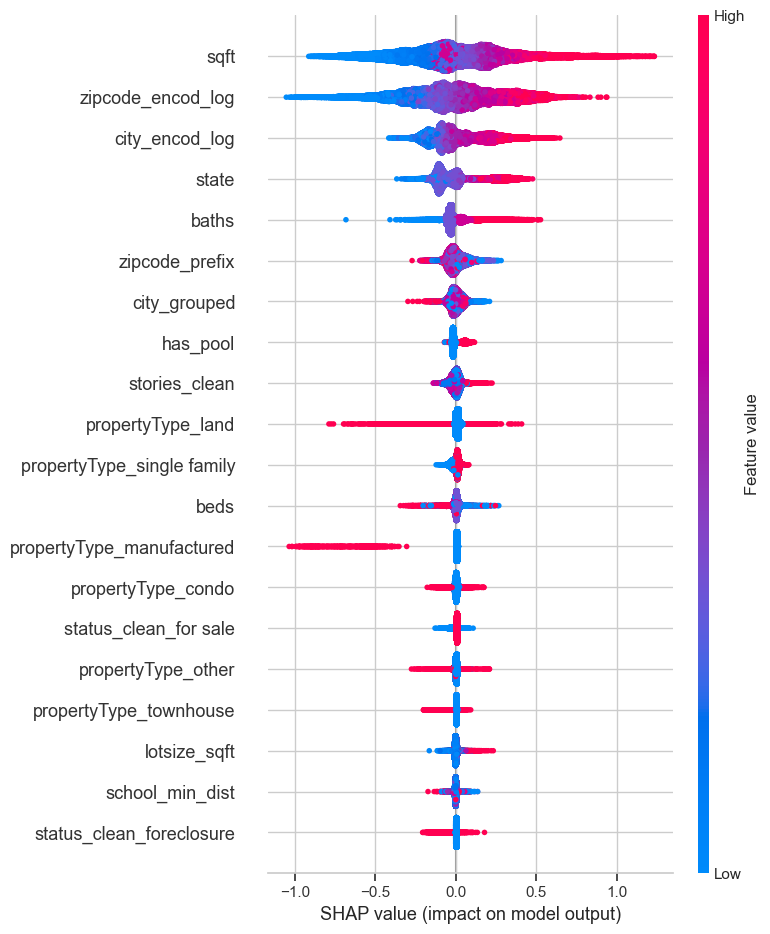

In [110]:
explainer = shap.Explainer(best_model)
shap_values = explainer(X_test)
#
# –ì–ª–æ–±–∞–ª—å–Ω–æ–µ –≤–ª–∏—è–Ω–∏–µ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤
shap.summary_plot(shap_values, X_test)
#

–∏–∑ –≥—Ä–∞—Ñ–∏–∫–∞ —Ñ–∏–¥–Ω–æ –∫–∞–∫ —Ä–∞—Å–ø–æ–ª–æ–∂–µ–Ω—ã –ø—Ä–∏–∑–Ω–∞–∫–∏ (—Å–≤–µ—Ä—Ö—É –≤–Ω–∏–∑) –ø–æ –∑–Ω–∞—á–∏–º–æ—Å—Ç–∏ –≤–ª–∏—è–Ω–∏—è –Ω–∞ —Ü–µ–ª–µ–≤–æ–π –ø—Ä–∏–∑–Ω–∞–∫. –ù–∞—à–µ –ø—Ä–µ–¥–ø–æ–ª–æ–∂–µ–Ω–∏–µ –æ –∑–Ω–∞—á–µ–Ω–∏–∏ –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ '**zipcode_encoded_log**', '**city_encoded_log**', '**sqft**', '**baths**, '**has_pool**', '**beds**' –ø–æ —Ä–µ–∑—É–ª—å—Ç–∞—Ç–∞–º –º–∞—Ç—Ä–∏—Ü—ã –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –≤ —Ü–µ–ª–æ–º —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤—É—é—Ç –≥—Ä–∞—Ñ–∏–∫—É. –ù–∞–¥–æ –ø–æ–Ω–∏–º–∞—Ç—å, —á—Ç–æ —Å—é–¥–∞ –≤–æ—à–ª–∏ –µ—â–µ –∏  
–∑–∞–∫–æ–¥–∏—Ä–æ–≤–∞–Ω–Ω—ã–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏.

### –ø–æ–¥–±–æ—Ä –Ω–∞—á–∞–ª—å–Ω—ã—Ö –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è **RandomForest**

—Ä—É—á–Ω–æ–π –ø–æ–¥–±–æ—Ä –ø–∞—Ä–∞–º–µ—Ç—Ä–æ–≤ –¥–ª—è RandomForest  ( –∞–≤—Ç–æ–º–∞—Ç–∏—á–µ—Å–∫–∏–π –∫–∞—Ç–µ–≥–æ—Ä–∏—á–µ—Å–∫–∏ –Ω–µ –ø–æ–º–µ—â–∞–ª—Å—è –ø–æ –≤—Ä–µ–º–µ–Ω–∏)

In [111]:
#
# –ë–∞–∑–æ–≤—ã–µ –ø–∞—Ä–∞–º–µ—Ç—Ä—ã, –∫–æ—Ç–æ—Ä—ã–µ –Ω–µ –º–µ–Ω—è—é—Ç—Å—è
params_base = {
    'ccp_alpha': 0.0,
    'min_impurity_decrease': 0.0,
    'min_weight_fraction_leaf': 0.0,
    'bootstrap': True,
    'oob_score': True,
    'random_state': 42,
    'n_jobs': -1
}
#
# –í–∞—Ä–∏–∞–Ω—Ç—ã –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π 
grid = [
    {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300},
    {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 400},
    {'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'n_estimators': 500},
    {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 400},
    {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 300},
    {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 500},
    {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300},
    {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 400},
    {'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'n_estimators': 500},
    {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 500},
    {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300},
    {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 400},
    {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300},
    {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 500},
    {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'n_estimators': 400},
]

# –ü–µ—Ä–µ–±–æ—Ä –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏–π –∏ –≤—ã–≤–æ–¥ –º–µ—Ç—Ä–∏–∫
for i, p in enumerate(grid, 1):
    config = {**params_base, **p}
    model = RandomForestRegressor(**config)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    mae = mean_absolute_error(y_test, y_pred)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)

    print(f"\nüîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è {i}: {p}")
    print(f"üìâ MAE: {mae:.2f}")
    print(f"üìâ RMSE: {rmse:.2f}")
    print(f"üìä R¬≤: {r2:.3f}")
    print(f"üß™ OOB R¬≤: {model.oob_score_:.3f}")


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 1: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300}
üìâ MAE: 0.25
üìâ RMSE: 0.38
üìä R¬≤: 0.760
üß™ OOB R¬≤: 0.763


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 2: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 400}
üìâ MAE: 0.25
üìâ RMSE: 0.38
üìä R¬≤: 0.757
üß™ OOB R¬≤: 0.762


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 3: {'max_depth': 25, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'n_estimators': 500}
üìâ MAE: 0.27
üìâ RMSE: 0.39
üìä R¬≤: 0.739
üß™ OOB R¬≤: 0.743


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 4: {'max_depth': 30, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 400}
üìâ MAE: 0.26
üìâ RMSE: 0.38
üìä R¬≤: 0.758
üß™ OOB R¬≤: 0.762


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 5: {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 300}
üìâ MAE: 0.27
üìâ RMSE: 0.39
üìä R¬≤: 0.746
üß™ OOB R¬≤: 0.749


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 6: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 500}
üìâ MAE: 0.26
üìâ RMSE: 0.38
üìä R¬≤: 0.756
üß™ OOB R¬≤: 0.760


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 7: {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300}
üìâ MAE: 0.26
üìâ RMSE: 0.38
üìä R¬≤: 0.756
üß™ OOB R¬≤: 0.760


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 8: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 400}
üìâ MAE: 0.25
üìâ RMSE: 0.38
üìä R¬≤: 0.760
üß™ OOB R¬≤: 0.763


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 9: {'max_depth': 35, 'min_samples_split': 7, 'min_samples_leaf': 3, 'max_features': 'sqrt', 'n_estimators': 500}
üìâ MAE: 0.27
üìâ RMSE: 0.39
üìä R¬≤: 0.744
üß™ OOB R¬≤: 0.747


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 10: {'max_depth': 30, 'min_samples_split': 5, 'min_samples_leaf': 3, 'max_features': 0.5, 'n_estimators': 500}
üìâ MAE: 0.25
üìâ RMSE: 0.38
üìä R¬≤: 0.758
üß™ OOB R¬≤: 0.762


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 11: {'max_depth': 25, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.7, 'n_estimators': 300}
üìâ MAE: 0.26
üìâ RMSE: 0.38
üìä R¬≤: 0.756
üß™ OOB R¬≤: 0.760


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 12: {'max_depth': 35, 'min_samples_split': 3, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'n_estimators': 400}
üìâ MAE: 0.27
üìâ RMSE: 0.39
üìä R¬≤: 0.747
üß™ OOB R¬≤: 0.750


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 13: {'max_depth': 30, 'min_samples_split': 7, 'min_samples_leaf': 2, 'max_features': 0.5, 'n_estimators': 300}
üìâ MAE: 0.25
üìâ RMSE: 0.38
üìä R¬≤: 0.759
üß™ OOB R¬≤: 0.763


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(



üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 14: {'max_depth': 25, 'min_samples_split': 3, 'min_samples_leaf': 3, 'max_features': 0.7, 'n_estimators': 500}
üìâ MAE: 0.25
üìâ RMSE: 0.38
üìä R¬≤: 0.757
üß™ OOB R¬≤: 0.762

üîß –ö–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è 15: {'max_depth': 35, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 0.5, 'n_estimators': 400}
üìâ MAE: 0.26
üìâ RMSE: 0.38
üìä R¬≤: 0.757
üß™ OOB R¬≤: 0.761


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


–≤ –∏—Ç–æ–≥–µ, –ª—É—á—à–∞—è –∫–æ–Ω—Ñ–∏–≥—É—Ä–∞—Ü–∏—è –æ–∫–∞–∑–∞–ª–∞—Å—å –ø–æ–¥ –Ω–æ–º–µ—Ä–æ–º **8**

 ### —Å—Ç—ç–∫–∏–Ω–≥ **–°atBoostRegressor** –∏ **RandomForest**   - –æ–±–µ –º–æ–¥–µ–ª–∏ —Å –ø–æ–¥–æ–±—Ä–∞–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏

In [112]:
#
# üîß –°–ª—É—á–∞–π–Ω—ã–π –ª–µ—Å —Å –ª—É—á—à–∏–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
rf_model = RandomForestRegressor(
    bootstrap=True,
    ccp_alpha=0.0,
    criterion='squared_error',
    max_depth=30,
    max_features=0.5,
    max_leaf_nodes=None,
    max_samples=None,
    min_impurity_decrease=0.0,
    min_samples_leaf=2,
    min_samples_split=5,
    min_weight_fraction_leaf=0.0,
    monotonic_cst=None,
    n_estimators=400,
    n_jobs=-1,
    oob_score=True,
    random_state=42,
    verbose=0,
    warm_start=False
)

# üêà CatBoost —Å –ø–æ–¥–æ–±—Ä–∞–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏
catboost_model = CatBoostRegressor(
    learning_rate=0.15,
    l2_leaf_reg=3,
    iterations=900,
    depth=9,
    border_count=64,
    bagging_temperature=0.5,
    verbose=0,
    random_state=42
)

# üß† –§–∏–Ω–∞–ª—å–Ω–∞—è –º–æ–¥–µ–ª—å (–º–µ—Ç–∞-–º–æ–¥–µ–ª—å)
meta_model = Ridge(alpha=1.0)

# üß™ –°—Ç–µ–∫
stack_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_model),
        ('rf', rf_model)
    ],
    final_estimator=meta_model,
    cv=5,
    n_jobs=-1
)

# üöÄ –û–±—É—á–µ–Ω–∏–µ
stack_model.fit(X_train, y_train)

# üìà –ü—Ä–µ–¥—Å–∫–∞–∑–∞–Ω–∏–µ
y_pred = stack_model.predict(X_test)
#

In [113]:
## üìä –ú–µ—Ç—Ä–∏–∫–∏ —Å—Ç—ç–∫–∏–Ω–≥–∞ –°atBoostRegressor –∏ RandomForest
#
mae_log = mean_absolute_error(y_test, y_pred)
rmse_log = mean_squared_error(y_test, y_pred, squared=False)
#
# –ü–µ—Ä–µ–≤–æ–¥–∏–º –∏–∑ –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–æ–π —à–∫–∞–ª—ã –æ–±—Ä–∞—Ç–Ω–æ –≤ –¥–æ–ª–ª–∞—Ä—ã
y_pred_dollars = np.expm1(y_pred)
y_test_dollars = np.expm1(y_test)
#
mae_dollars  = mean_absolute_error(y_test_dollars, y_pred_dollars)
rmse_dollars = mean_squared_error(y_test_dollars, y_pred_dollars, squared=False)
#
# üìä –ú–µ—Ç—Ä–∏–∫–∏
print(f"üìà MAE: {mean_absolute_error(y_test, y_pred):.3f} ({mae_dollars:.1f} $)")
print(f"üìâ RMSE: {mean_squared_error(y_test, y_pred, squared=False):.3f} ({rmse_dollars:.1f} $)")
print(f"üìä R¬≤: {r2_score(y_test, y_pred):.3f}")

üìà MAE: 0.252 (111891.5 $)
üìâ RMSE: 0.375 (207950.9 $)
üìä R¬≤: 0.764


c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


### —Å–æ—Ö—Ä–∞–Ω—è–µ–º —Ñ–∏–Ω–∞–ª—å–Ω—É—é –º–æ–¥–µ–ª—å –≤ —Ñ–∞–π–ª **catboost_rf_model.cbm**

In [114]:
#
# –°–æ—Ö—Ä–∞–Ω—è–µ–º –º–æ–¥–µ–ª—å –≤ —Ñ–∞–π–ª
##stack_model.save_model("catboost_rf_model.cbm")
joblib.dump(stack_model, "stack_model.pkl")


['stack_model.pkl']

### **–û—Å–Ω–æ–≤–Ω—ã–µ —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –∏ –≤—ã–≤–æ–¥—ã**

- –ø—Ä–æ–≤–µ–¥–µ–Ω–∞ –∑–Ω–∞—á–∏—Ç–µ–ª—å–Ω–∞—è –æ—á–∏—Å—Ç–∫–∞ –¥–∞–Ω–Ω—ã—Ö data.csv. –í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ –ø–æ–ª—É—á–µ–Ω–∞ —Ç–∞–±–ª–∏—Ü–∞ –±–µ–∑ –ø—Ä–æ–ø—É—Å–∫–æ–≤ df_cleaned  
- –ø—Ä–µ–æ–±—Ä–∞–∑–æ–≤–∞–Ω—ã –∏ –¥–æ–±–∞–≤–ª–µ–Ω—ã –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
- –∑–∞–∫–æ–¥–∏—Ä–æ–≤–∞–Ω—ã –≤—Å–µ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏
- –æ—Å–Ω–æ–≤–Ω—ã–º–∏ —á–∏—Å–ª–æ–≤—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∞–º–∏, –≤–ª–∏—è—é—â–∏–º–∏ –Ω–∞ —Ü–µ–ª–µ–≤—É—é –ø–µ—Ä–µ–º–µ–Ω–Ω—É—é (target_log - –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–∞—è —Ü–µ–Ω–∞ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏) –≤ —Å–æ–æ—Ç–≤–µ—Ç—Å—Ç–≤–∏–∏ —Å –º–∞—Ç—Ä–∏—Ü–µ–π –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ —è–≤–ª—è—é—Ç—Å—è:  

  zipcode_encod_log ( –ª–æ–≥–∞—Ä–∏—Ñ–º–∏—á–µ—Å–∫–∞—è –º–µ–¥–∏–∞–Ω–Ω–∞—è —Ü–µ–Ω–∞ –ø–æ –∑–∏–ø–∫–æ–¥—É);  
  city_encod_log (—Ç–æ–∂–µ —Å–∞–º–æ–µ –ø–æ –≥–æ—Ä–æ–¥–∞–º);  
  sqft (–ø–ª–æ—â–∞–¥—å –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ –≤ –∫–≤–∞–¥—Ä–∞—Ç–Ω—ã—Ö —Ñ—É—Ç–∞—Ö);  
  baths (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–∞–Ω–Ω—ã—Ö –∫–æ–º–Ω–∞—Ç);  
  has_pool (–Ω–∞–ª–∏—á–∏–µ –±–∞—Å—Å–µ–π–Ω–∞);  
  beds (–∫–æ–ª–∏—á–µ—Å—Ç–≤–æ —Å–ø–∞–ª–µ–Ω)  
- –ø–µ—Ä–≤—ã–µ 20 —á–∏—Å–ª–æ–≤—ã—Ö –∏ –∫–∞—Ç–µ–≥–æ—Ä–∏–∞–ª—å–Ω—ã—Ö –ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –ø–æ —Å—Ç–µ–ø–µ–Ω–∏ –≤–ª–∏—è–Ω–∏—è –Ω–∞ —Ä–µ–∑—É–ª—å—Ç–∞—Ç –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω—ã –Ω–∞ –≥—Ä–∞—Ñ–∏–∫–µ  summary_plot  

- —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã –ø—Ä–æ—Å—Ç–æ–π linear reagassion:  

                                       MAE: 0.349 (157383.0 $)  
                                    üìâ RMSE: 0.479 (290115.9 $)  
                                    üìä R¬≤: 0.617  

- —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã randome forest:  

                               üìâ MAE: 0.25  
                               üìâ RMSE: 0.38  
                               üìä R¬≤: 0.760  
                               üß™ OOB R¬≤: 0.763  

- —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã catboosting:   üìà R¬≤ –Ω–∞ –∫—Ä–æ—Å—Å-–≤–∞–ª–∏–¥–∞—Ü–∏–∏: 0.751  
                            üìâ MAE: 0.261  
                            üìâ RMSE: 0.383  
                            üìä R¬≤ –Ω–∞ —Ç–µ—Å—Ç–µ: 0.755  

- —Ä–µ–∑—É–ª—å—Ç–∞—Ç—ã —Å—Ç—ç–∫–∏–Ω–≥–∞ rf –∏ catboosting :  

                            üìà MAE: 0.252 (111891.5 $)  
                            üìâ RMSE: 0.375 (207950.9 $)  
                            üìä R¬≤: 0.764  

–í —Ä–µ–∑—É–ª—å—Ç–∞—Ç–µ , —Å –º–∏–Ω–∏–º–∞–ª—å–Ω—ã–º –ø–µ—Ä–µ—Å–µ–≤–æ–º "–ø–æ–±–µ–¥–∏–ª" —Å—Ç—ç–∫–∏–Ω–≥.  

–í –∫–∞—á–µ—Å—Ç–≤–µ –∏—Ç–æ–≥–æ–≤–æ–≥–æ –ø—Ä–µ–¥—Å—Ç–∞–≤–ª–µ–Ω–∏—è —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ —Å–æ–∑–¥–∞–Ω –º–∏–Ω–∏–º–∞–ª—å–Ω—ã–π –≤–µ–± —Å–µ—Ä–≤–∏—Å, –≤ –∫–æ—Ç–æ—Ä—ã–π –º–æ–∂–Ω–æ –≤ –∏—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω–æ–º —Ä–µ–∂–∏–º–µ –∑–∞–Ω–µ—Å—Ç–∏ –Ω–µ–∫–æ—Ç–æ—Ä—ã–µ –æ—Å–Ω–æ–≤–Ω—ã–µ  
–ø—Ä–∏–∑–Ω–∞–∫–∏ –Ω–µ–¥–≤–∏–∂–∏–º–æ—Å—Ç–∏ –∏ –ø–æ–ª—É—á–∏—Ç—å –ø—Ä–æ–≥–Ω–æ–∑. –û—Å—Ç–∞–ª—å–Ω—ã–µ –ø—Ä–∏–∑–Ω–∞–∫–∏ –±–µ—Ä—É—Ç—Å—è –ø–æ–∫–∞ –ø–æ —É–º–æ–ª—á–∞–Ω–∏.   –ö–æ–ª–∏—á–µ—Å—Ç–≤–æ –≤–≤–æ–¥–∏–º—ã—Ö –≤ –∏–Ω—Ç–µ—Ä–∞–∫—Ç–∏–≤–Ω–æ–º —Ä–µ–∂–∏–º–µ  
–ø—Ä–∏–∑–Ω–∞–∫–æ–≤ –º–æ–∂–µ—Ç –±—ã—Ç—å —Ä–∞—Å—à–∏—Ä–µ–Ω–æ.